With this notebook you can reproduce the results from the paper <br> **X-ray irradiation and evaporation of the four young planets around V1298 Tau - Poppenhaeger, Ketzer, Mallonn (2020)**
.

# Import

In [48]:
import sys
sys.path.append('../platypos_package/')

# Planet Class
from Planet_class_LoFo14_PAPER import planet_LoFo14_PAPER # this is the code with fixed step size
from Planet_class_LoFo14 import planet_LoFo14 # this is the code with variable step size
from Planet_class_Ot20_PAPER import planet_Ot20_PAPER # this is the code with fixed step size
from Planet_class_Ot20 import planet_Ot20  # this is the code with variable step size
import Planet_models_LoFo14 as plmo14
import Planet_model_Ot20 as plmoOt20
from Lx_evo_and_flux import Lx_evo, flux_at_planet_earth

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib
matplotlib.rcParams.update({'font.size': 18, 'legend.fontsize': 14})
mpl.rcParams['axes.linewidth'] = 1.1 #set the value globally
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import matplotlib.ticker as ticker
import os
from astropy import constants as const
from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive
from PyAstronomy import pyasl
from sklearn.neighbors import KernelDensity

p = "../supplementary_files/"
# Tu et al. (2015) - model tracks
blueTu15 = pd.read_csv(p+'Lx_blue_track.csv')
redTu15 = pd.read_csv(p+'Lx_red_track.csv')
greenTu15 = pd.read_csv(p+'Lx_green_track.csv')
                    
# Jackson et al. (2012) - Lx sample
jack12 = pd.read_csv(p+"Jackson2012_Lx_clean.csv")

def read_results_file(path, filename):
    # read in results files
    df = pd.read_csv(path+filename)
    t, M, R, Lx = df["Time"].values, df["Mass"].values, df["Radius"].values, df["Lx"].values
    return t, M, R, Lx

## Present V1298 Tau parameters, $L_x$ evolutionary tracks, and planet models
First we need to define all the necessary system parameters. <br>
This includes the host star parameters, parameters to set the shape of the assumed future $L_x$ evolutionary tracks, and the planets themselves. <br>
To model the radius evolution of the planets we use the results from *Lopez & Fortney (2014)* and *Otegi et al. (2020)*.


In [29]:
# Stellar Parameters:
L_sun = const.L_sun
L_bol = 0.934 # David et al. 2019
mass_star, radius_star = 1.101, 1.345 # solar units
age_star = 23. # Myr
Lx_age = Lx_chandra = 1.3e30  # erg/s in energy band: (0.1-2.4 keV), error +- 1.4e29
Lx_age_error = 1.4e29
# use dictionary to store star-parameters
star_V1298Tau = {'star_id': 'V1298Tau', 'mass': mass_star, 'radius': radius_star, 'age': age_star, 'L_bol': L_bol, 'Lx_age': Lx_age}
age = star_V1298Tau["age"]

# Lx evolutionary tracks:
# create dictionaries with all the values necessary to create the evolutionary paths
Lx_1Gyr = 2.10*10**28  # Lx value at 1 Gyr from Tu et al. (2015) model tracks
Lx_5Gyr = 1.65*10**27  # Lx value at 5 Gyr from Tu et al. (2015) model tracks
track1 = {"t_start": age, "t_sat": 240., "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age, "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 0., "Lx_drop_factor": 0.}
track2 = {"t_start": age, "t_sat": age, "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age, "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 0., "Lx_drop_factor": 0.}
#track2_2 = {"t_start": age, "t_sat": 70., "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age, "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 20., "Lx_drop_factor": 5.}
#track2_3 = {"t_start": age, "t_sat": 100., "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age, "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 0., "Lx_drop_factor": 0.}
track3 = {"t_start": age, "t_sat": age, "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age, "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 20., "Lx_drop_factor": 16.}

track1_lower = {"t_start": age, "t_sat": 240., "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age-Lx_age_error, "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 0., "Lx_drop_factor": 0.}
track2_lower = {"t_start": age, "t_sat": age, "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age-Lx_age_error, "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 0., "Lx_drop_factor": 0.}
#track2_2_lower = {"t_start": age, "t_sat": 70., "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age-Lx_age_error, "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 20., "Lx_drop_factor": 5.}
#track2_3_lower = {"t_start": age, "t_sat": 100., "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age-Lx_age_error, "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 0., "Lx_drop_factor": 0.}
track3_lower = {"t_start": age, "t_sat": age, "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age-Lx_age_error, "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 20., "Lx_drop_factor": 16.}

track1_upper = {"t_start": age, "t_sat": 240., "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age+Lx_age_error, "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 0., "Lx_drop_factor": 0.}
track2_upper = {"t_start": age, "t_sat": age, "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age+Lx_age_error, "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 0., "Lx_drop_factor": 0.}
#track2_2_upper = {"t_start": age, "t_sat": 70., "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age+Lx_age_error, "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 20., "Lx_drop_factor": 5.}
#track2_3_upper = {"t_start": age, "t_sat": 100., "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age+Lx_age_error, "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 0., "Lx_drop_factor": 0.}
track3_upper = {"t_start": age, "t_sat": age, "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age+Lx_age_error, "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 20., "Lx_drop_factor": 16.}


# Create planet objects using either LoFO14 or Ot20 results:
R_c, R_d, R_b, R_e = 5.59, 6.41, 10.27, 8.74
a_c, a_d, a_b, a_e = 0.0825, 0.1083, 0.1688, 0.308
# 'fluffy' LoFo14 planets with 5 M_earth core
planet_c = {"core_mass": 5.0, "radius": R_c, "distance": a_c, "metallicity": "solarZ"}
planet_d = {"core_mass": 5.0, "radius": R_d, "distance": a_d, "metallicity": "solarZ"}
planet_b = {"core_mass": 5.0, "radius": R_b, "distance": a_b, "metallicity": "solarZ"}
planet_e = {"core_mass": 5.0, "radius": R_e, "distance": a_e, "metallicity": "solarZ"}

# fixed step size
pl_c_5_PAPER = planet_LoFo14_PAPER(star_dictionary=star_V1298Tau, planet_dict=planet_c)
pl_d_5_PAPER = planet_LoFo14_PAPER(star_dictionary=star_V1298Tau, planet_dict=planet_d)
pl_b_5_PAPER = planet_LoFo14_PAPER(star_dictionary=star_V1298Tau, planet_dict=planet_b)
pl_e_5_PAPER = planet_LoFo14_PAPER(star_dictionary=star_V1298Tau, planet_dict=planet_e)

# variable step size
pl_c_5 = planet_LoFo14(star_dictionary=star_V1298Tau, planet_dict=planet_c)
pl_d_5 = planet_LoFo14(star_dictionary=star_V1298Tau, planet_dict=planet_d)
pl_b_5 = planet_LoFo14(star_dictionary=star_V1298Tau, planet_dict=planet_b)
pl_e_5 = planet_LoFo14(star_dictionary=star_V1298Tau, planet_dict=planet_e)

# 'fluffy' LoFo14 planets with 10 M_earth core
planet_c = {"core_mass": 10.0, "radius": R_c, "distance": a_c, "metallicity": "solarZ"}
planet_d = {"core_mass": 10.0, "radius": R_d, "distance": a_d, "metallicity": "solarZ"}
planet_b = {"core_mass": 10.0, "radius": R_b, "distance": a_b, "metallicity": "solarZ"}
planet_e = {"core_mass": 10.0, "radius": R_e, "distance": a_e, "metallicity": "solarZ"}

# fixed step size
pl_c_10_PAPER = planet_LoFo14_PAPER(star_dictionary=star_V1298Tau, planet_dict=planet_c)
pl_d_10_PAPER = planet_LoFo14_PAPER(star_dictionary=star_V1298Tau, planet_dict=planet_d)
pl_b_10_PAPER = planet_LoFo14_PAPER(star_dictionary=star_V1298Tau, planet_dict=planet_b)
pl_e_10_PAPER = planet_LoFo14_PAPER(star_dictionary=star_V1298Tau, planet_dict=planet_e)

# variable step size
pl_c_10 = planet_LoFo14(star_dictionary=star_V1298Tau, planet_dict=planet_c)
pl_d_10 = planet_LoFo14(star_dictionary=star_V1298Tau, planet_dict=planet_d)
pl_b_10 = planet_LoFo14(star_dictionary=star_V1298Tau, planet_dict=planet_b)
pl_e_10 = planet_LoFo14(star_dictionary=star_V1298Tau, planet_dict=planet_e)

# 'high-density' Ot20 planets
planet_c = {"radius": R_c, "distance": a_c}
planet_d = {"radius": R_d, "distance": a_d}
planet_b = {"radius": R_b, "distance": a_b}
planet_e = {"radius": R_e, "distance": a_e}

# fixed step size
pl_c_Ot_PAPER = planet_Ot20_PAPER(star_dictionary=star_V1298Tau, planet_dict=planet_c)
pl_d_Ot_PAPER = planet_Ot20_PAPER(star_dictionary=star_V1298Tau, planet_dict=planet_d)
pl_b_Ot_PAPER = planet_Ot20_PAPER(star_dictionary=star_V1298Tau, planet_dict=planet_b)
pl_e_Ot_PAPER = planet_Ot20_PAPER(star_dictionary=star_V1298Tau, planet_dict=planet_e)

# variable step size
pl_c_Ot = planet_Ot20(star_dictionary=star_V1298Tau, planet_dict=planet_c)
pl_d_Ot = planet_Ot20(star_dictionary=star_V1298Tau, planet_dict=planet_d)
pl_b_Ot = planet_Ot20(star_dictionary=star_V1298Tau, planet_dict=planet_b)
pl_e_Ot = planet_Ot20(star_dictionary=star_V1298Tau, planet_dict=planet_e)

## Plot current V1298 Tau $L_x$ & evolutionary tracks

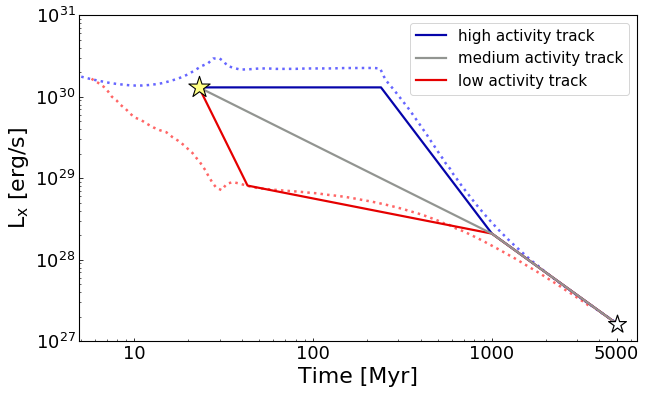

In [30]:
fig, ax = plt.subplots(figsize=(10,6))
#ax.set_title('$L_x$ evolution for different "evolutionary tracks"')

# plot Tu15 tracks (for a Sun-like star!)
ax.plot(blueTu15["time"], blueTu15["Lx"], marker="None", linestyle=":", color="blue", linewidth=2.5, alpha=0.6, label="__nolabel__")#, label="fast rot. (solar model)")
ax.plot(redTu15["time"], redTu15["Lx"], marker="None", linestyle=":", color="red", linewidth=2.5, alpha=0.6, label="__nolabel__")#, label="slow rot. (solar model)")
#ax.plot(greenTu15["time"], greenTu15["Lx"], marker="None", linestyle=":", color="lime", linewidth=2.5, alpha=0.5, label="__nolabel__")#, label="interm. rot. (solar model)")

# plot approximated tracks
step_size, t_track_start, t_track_end = 1., age, 5000. # Myr
t_arr = np.arange(t_track_start, t_track_end+step_size, step_size)
Lx_arr = np.array([Lx_evo(t=t_i, track_dict=track1) for t_i in t_arr])
ax.plot(t_arr, Lx_arr, color="xkcd:royal blue", ls="-", zorder=2, label="high activity track", lw=2.2)
#####
Lx_arr = np.array([Lx_evo(t=t_i, track_dict=track2) for t_i in t_arr])
ax.plot(t_arr, Lx_arr, color="xkcd:grey", zorder=3, lw=2.2, alpha=1., label="medium activity track")
#####
Lx_arr = np.array([Lx_evo(t=t_i, track_dict=track3) for t_i in t_arr])
ax.plot(t_arr, Lx_arr, color="xkcd:red", zorder=2, label="low activity track", alpha=1, ls="-", lw=2.2)

# plot current X-ray luminosity of V1298 Tau as measured with Chandra & the assumed X-ray luminosity at 5 Gyr
ax.scatter(age, Lx_chandra, marker='*', c='xkcd:pale yellow', edgecolors='black', linewidths=1.1, s=500, alpha=1, zorder=4, label="__nolabel__")#, label="today"
ax.scatter(5000., Lx_5Gyr, marker='*', c='white', edgecolors='black', linewidths=1.2, s=350, zorder=4, label="__nolabel__")#,  label="at 5 Gyr"

ax.loglog()
ax.set_xlabel("Time [Myr]", fontsize=22)
ax.set_ylabel("L$_\mathrm{x}$ [erg/s]", fontsize=22)
ax.set_xticks([10, 100, 1000, 5000])
ax.set_yticks([10**27., 10**28., 10**29., 10**30., 10**31.])
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
ax.set_xlim(left=4.9, right=6500)
ylim = ax.get_ylim()
ax.set_ylim(abs(ylim[0]), ylim[1])
ax.set_ylim(10.**27, ylim[1])
ax.tick_params(direction="in", which="both", labelsize=18)
ax.legend(loc="best", fontsize=15)
#plt.savefig("./Plots_PAPER/Activity_tracks_v1298Tau_largelabels.jpg", dpi=300)
#plt.savefig("./Plots_PAPER/Fig8_largelabels.jpg", dpi=300)

plt.show()

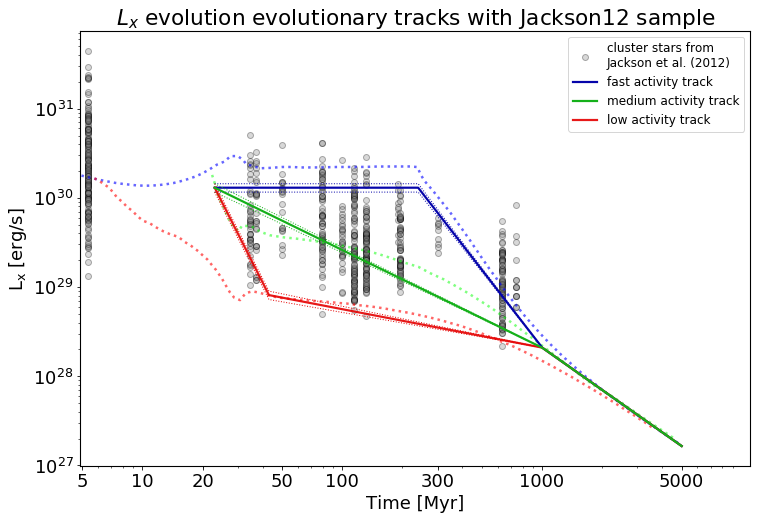

In [31]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('$L_x$ evolution evolutionary tracks with Jackson12 sample')

# plot Tu15 tracks (for a Sun-like star!)
ax.plot(blueTu15["time"], blueTu15["Lx"], marker="None", linestyle=":", color="blue", linewidth=2.5, alpha=0.6, label="__nolabel__")#, label="fast rot. (solar model)")
ax.plot(redTu15["time"], redTu15["Lx"], marker="None", linestyle=":", color="red", linewidth=2.5, alpha=0.6, label="__nolabel__")#, label="slow rot. (solar model)")
ax.plot(greenTu15["time"], greenTu15["Lx"], marker="None", linestyle=":", color="lime", linewidth=2.5, alpha=0.5, label="__nolabel__")#, label="interm. rot. (solar model)")
ax.plot(jack12["age"]/1e6, 10**jack12["logLx_cgs"], ls="None", marker="o", color="grey", mec="k", alpha=0.3, zorder=1, label="cluster stars from \nJackson et al. (2012)")

# plot approximated tracks
step_size, t_track_start, t_track_end = 1., age, 5000. # Myr
t_arr = np.arange(t_track_start, t_track_end+step_size, step_size)
Lx_arr = np.array([Lx_evo(t=t_i, track_dict=track1) for t_i in t_arr])
ax.plot(t_arr, Lx_arr, color="xkcd:royal blue", ls="-", zorder=2, label="fast activity track", lw=2.2)
# 1 sigma errorbars on Lx at 23 Myr
Lx_arr = np.array([Lx_evo(t=t_i, track_dict=track1_lower) for t_i in t_arr])
ax.plot(t_arr, Lx_arr, color="xkcd:royal blue", ls=":", zorder=2, label="__nolabel__", lw=1)
Lx_arr = np.array([Lx_evo(t=t_i, track_dict=track1_upper) for t_i in t_arr])
ax.plot(t_arr, Lx_arr, color="xkcd:royal blue", ls=":", zorder=2, label="__nolabel__", lw=1)
#####
Lx_arr = np.array([Lx_evo(t=t_i, track_dict=track2) for t_i in t_arr])
ax.plot(t_arr, Lx_arr, color="xkcd:green", zorder=3, lw=2.2, alpha=1., label="medium activity track")
# 1 sigma errorbars on Lx at 23 Myr
Lx_arr = np.array([Lx_evo(t=t_i, track_dict=track2_lower) for t_i in t_arr])
ax.plot(t_arr, Lx_arr, color="xkcd:green", ls=":", zorder=2, label="__nolabel__", lw=1)
Lx_arr = np.array([Lx_evo(t=t_i, track_dict=track2_upper) for t_i in t_arr])
ax.plot(t_arr, Lx_arr, color="xkcd:green", ls=":", zorder=2, label="__nolabel__", lw=1)
#####
Lx_arr = np.array([Lx_evo(t=t_i, track_dict=track3) for t_i in t_arr])
ax.plot(t_arr, Lx_arr, color="xkcd:red", zorder=2, label="low activity track", alpha=0.9, ls="-", lw=2.2)
# 1 sigma errorbars on Lx at 23 Myr
Lx_arr = np.array([Lx_evo(t=t_i, track_dict=track3_lower) for t_i in t_arr])
ax.plot(t_arr, Lx_arr, color="xkcd:red", ls=":", zorder=2, label="__nolabel__", lw=1)
Lx_arr = np.array([Lx_evo(t=t_i, track_dict=track3_upper) for t_i in t_arr])
ax.plot(t_arr, Lx_arr, color="xkcd:red", ls=":", zorder=2, label="__nolabel__", lw=1)

ax.loglog()
ax.set_xlabel("Time [Myr]")
ax.set_ylabel("L$_\mathrm{x}$ [erg/s]")
ax.set_xticks([5, 10, 20, 50, 100, 300, 1000, 5000])
ax.set_yticks([10**27., 10**28., 10**29., 10**30., 10**31.])
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
ax.set_xlim(left=4.9, right=11000)
ylim = ax.get_ylim()
ax.set_ylim(abs(ylim[0]), ylim[1])
ax.legend(loc="best", fontsize=12)
#plt.savefig("./tracks_v1298Tau.png", dpi=300)
plt.show()

# Evolve LoFo14_PAPER planets (fixed step size)

### Evolve LoFo14_PAPER planets w. 10 Mcore

In [32]:
%%time
try:
    p = os.getcwd()+"/LoFo14_Results_PAPER/10_Mcore/"
    os.mkdir(p)
    curr_path = p
    print(curr_path)
except:
    try:
        os.mkdir(os.getcwd()+"/LoFo14_Results_PAPER/")
        os.mkdir(os.getcwd()+"/LoFo14_Results_PAPER/10_Mcore/")
        curr_path = os.getcwd()+"/LoFo14_Results_PAPER/10_Mcore/"
        print(curr_path)
    except:  
        print("Path exists")
        curr_path = os.getcwd()+"/LoFo14_Results_PAPER/10_Mcore/"
        print(curr_path)
    
folders = ["planet_c", "planet_d", "planet_b", "planet_e"]
for f in folders:
    if os.path.isdir(curr_path+f) == True:
        pass
    else:
        os.mkdir(curr_path+f)

# set epsilon, the step size, and how far into the future you want to evolve the planet
eps, step_size, t_final = 0.1, 0.1, 5000.
# planet c
folder = folders[0]
pl_c_10_PAPER.evolve_forward(t_final=t_final, initial_step_size=step_size, epsilon=eps, K_on="yes", beta_on="yes", 
                             evo_track_dict=track1, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_c_10P, M1_c_10P, R1_c_10P, Lx1_c_10 = pl_c_10_PAPER.read_results(curr_path+folder+"/")
pl_c_10_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                             path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_c_10P, M2_c_10P, R2_c_10P, Lx2_c_10 = pl_c_10_PAPER.read_results(curr_path+folder+"/")
pl_c_10_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                             path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_c_10P, M3_c_10P, R3_c_10P, Lx3_c_10 = pl_c_10_PAPER.read_results(curr_path+folder+"/")

# planet d
folder = folders[1]
pl_d_10_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                             path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_d_10P, M1_d_10P, R1_d_10P, Lx1_d_10P = pl_d_10_PAPER.read_results(curr_path+folder+"/")
pl_d_10_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                             path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_d_10P, M2_d_10P, R2_d_10P, Lx2_d_10P = pl_d_10_PAPER.read_results(curr_path+folder+"/")
pl_d_10_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                             path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_d_10P, M3_d_10P, R3_d_10P, Lx3_d_10P = pl_d_10_PAPER.read_results(curr_path+folder+"/")

# change step size to 1 Myr for outer planets otherwise it takes quite some time
step_size = 1.
# planet b
folder = folders[2]
pl_b_10_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                             path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_b_10P, M1_b_10P, R1_b_10P, Lx1_b_10P_2 = pl_b_10_PAPER.read_results(curr_path+folder+"/")
pl_b_10_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                             path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_b_10P, M2_b_10P, R2_b_10P, Lx2_b_10P_2 = pl_b_10_PAPER.read_results(curr_path+folder+"/")
pl_b_10_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                             path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_b_10P, M3_b_10P, R3_b_10P, Lx3_b_10P_2 = pl_b_10_PAPER.read_results(curr_path+folder+"/")

# planet e
folder = folders[3]
pl_e_10_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                             path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_e_10P, M1_e_10P, R1_e_10P, Lx1_e_10P_2 = pl_e_10_PAPER.read_results(curr_path+folder+"/")
pl_e_10_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                             path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_e_10P, M2_e_10P, R2_e_10P, Lx2_e_10P_2 = pl_e_10_PAPER.read_results(curr_path+folder+"/")
pl_e_10_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                             path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_e_10P, M3_e_10P, R3_e_10P, Lx3_e_10P_2 = pl_e_10_PAPER.read_results(curr_path+folder+"/")

Path exists
/media/laura/SSD2lin/PhD/work/gitlab/platypos/example_V1298Tau/LoFo14_Results_PAPER/10_Mcore/
CPU times: user 333 ms, sys: 15.9 ms, total: 349 ms
Wall time: 372 ms


### Evolve LoFo14_PAPER planets w. 5 Mcore

In [33]:
%%time
try:
    p = os.getcwd()+"/LoFo14_Results_PAPER/5_Mcore/"
    os.mkdir(p)
    curr_path = p
    print(curr_path)
except:
    try:
        os.mkdir(os.getcwd()+"/LoFo14_Results_PAPER/")
        os.mkdir(os.getcwd()+"/LoFo14_Results_PAPER/5_Mcore/")
        curr_path = os.getcwd()+"/LoFo14_Results_PAPER/5_Mcore/"
        print(curr_path)
    except:  
        print("Path exists")
        curr_path = os.getcwd()+"/LoFo14_Results_PAPER/5_Mcore/"
        print(curr_path)
    
folders = ["planet_c", "planet_d", "planet_b", "planet_e"]
for f in folders:
    if os.path.isdir(curr_path+f) == True:
        pass
    else:
        os.mkdir(curr_path+f)

# set epsilon, the step size, and how far into the future you want to evolve the planet
eps, step_size, t_final = 0.1, 0.1, 5000.
# planet c
folder = folders[0]
pl_c_5_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                            path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_c_5P, M1_c_5P, R1_c_5P, Lx1_c_5P = pl_c_5_PAPER.read_results(curr_path+folder+"/")
pl_c_5_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                            path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_c_5P, M2_c_5P, R2_c_5P, Lx2_c_5P = pl_c_5_PAPER.read_results(curr_path+folder+"/")
pl_c_5_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                            path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_c_5P, M3_c_5P, R3_c_5P, Lx3_c_5P = pl_c_5_PAPER.read_results(curr_path+folder+"/")

# planet d
folder = folders[1]
pl_d_5_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                            path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_d_5P, M1_d_5P, R1_d_5P, Lx1_d_5P = pl_d_5_PAPER.read_results(curr_path+folder+"/")
pl_d_5_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                            path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_d_5P, M2_d_5P, R2_d_5P, Lx2_d_5P = pl_d_5_PAPER.read_results(curr_path+folder+"/")
pl_d_5_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                            path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_d_5P, M3_d_5P, R3_d_5P, Lx3_d_5P = pl_d_5_PAPER.read_results(curr_path+folder+"/")

# planet b
folder = folders[2]
pl_b_5_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                            path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_b_5P, M1_b_5P, R1_b_5P, Lx1_b_5P_2 = pl_b_5_PAPER.read_results(curr_path+folder+"/")
pl_b_5_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                            path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_b_5P, M2_b_5P, R2_b_5P, Lx2_b_5P_2 = pl_b_5_PAPER.read_results(curr_path+folder+"/")
pl_b_5_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                            path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_b_5P, M3_b_5P, R3_b_5P, Lx3_b_5P_2 = pl_b_5_PAPER.read_results(curr_path+folder+"/")

# planet e
folder = folders[3]
pl_e_5_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                            path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_e_5P, M1_e_5P, R1_e_5P, Lx1_e_5P_2 = pl_e_5_PAPER.read_results(curr_path+folder+"/")
pl_e_5_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                            path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_e_5P, M2_e_5P, R2_e_5P, Lx2_e_5P_2 = pl_e_5_PAPER.read_results(curr_path+folder+"/")
pl_e_5_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                            path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_e_5P, M3_e_5P, R3_e_5P, Lx3_e_5P_2 = pl_e_5_PAPER.read_results(curr_path+folder+"/")

Path exists
/media/laura/SSD2lin/PhD/work/gitlab/platypos/example_V1298Tau/LoFo14_Results_PAPER/5_Mcore/
CPU times: user 370 ms, sys: 20.1 ms, total: 390 ms
Wall time: 415 ms


### Evolve Ot20_PAPER Planets

In [34]:
%%time
try:
    p = os.getcwd()+"/Otegi_results_PAPER/"
    os.mkdir(p)
    curr_path = p
    print(curr_path)
except:
    print("Path exists")
    curr_path = os.getcwd()+"/Otegi_results_PAPER/"
    print(curr_path)

folders = ["planet_c", "planet_d", "planet_b", "planet_e"]
for f in folders:
    if os.path.isdir(curr_path+f) == True:
        pass
    else:
        os.mkdir(curr_path+f)

# set epsilon, the step size, and how far into the future you want to evolve the planet
eps, step_size, t_final = 0.1, 10., 5000.
# planet c
folder = folders[0]
pl_c_Ot_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_c_OtP, M1_c_OtP, R1_c_OtP, Lx1_c_OtP = pl_c_Ot_PAPER.read_results(curr_path+folder+"/")
pl_c_Ot_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_c_OtP, M2_c_OtP, R2_c_OtP, Lx2_c_OtP = pl_c_Ot_PAPER.read_results(curr_path+folder+"/")
pl_c_Ot_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_c_OtP, M3_c_OtP, R3_c_OtP, Lx3_c_OtP = pl_c_Ot_PAPER.read_results(curr_path+folder+"/")

# planet d
folder = folders[1]
pl_d_Ot_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_d_OtP, M1_d_OtP, R1_d_OtP, Lx1_d_OtP = pl_d_Ot_PAPER.read_results(curr_path+folder+"/")
pl_d_Ot_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_d_OtP, M2_d_OtP, R2_d_OtP, Lx2_d_OtP = pl_d_Ot_PAPER.read_results(curr_path+folder+"/")
pl_d_Ot_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_d_OtP, M3_d_OtP, R3_d_OtP, Lx3_d_OtP = pl_d_Ot_PAPER.read_results(curr_path+folder+"/")

# planet b
folder = folders[2]
pl_b_Ot_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_b_OtP, M1_b_OtP, R1_b_OtP, Lx1_b_OtP = pl_b_Ot_PAPER.read_results(curr_path+folder+"/")
pl_b_Ot_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_b_OtP, M2_b_OtP, R2_b_OtP, Lx2_b_OtP = pl_b_Ot_PAPER.read_results(curr_path+folder+"/")
pl_b_Ot_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_b_OtP, M3_b_OtP, R3_b_OtP, Lx3_b_OtP = pl_b_Ot_PAPER.read_results(curr_path+folder+"/")

# planet e
folder = folders[3]
pl_e_Ot_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_e_OtP, M1_e_OtP, R1_e_OtP, Lx1_e_OtP = pl_e_Ot_PAPER.read_results(curr_path+folder+"/")
pl_e_Ot_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_e_OtP, M2_e_OtP, R2_e_OtP, Lx2_e_OtP = pl_e_Ot_PAPER.read_results(curr_path+folder+"/")
pl_e_Ot_PAPER.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_e_OtP, M3_e_OtP, R3_e_OtP, Lx3_e_OtP = pl_e_Ot_PAPER.read_results(curr_path+folder+"/")

Path exists
/media/laura/SSD2lin/PhD/work/gitlab/platypos/example_V1298Tau/Otegi_results_PAPER/
CPU times: user 26.3 ms, sys: 4.07 ms, total: 30.4 ms
Wall time: 34.3 ms


# Evolve LoFo14 planets (code with variable step size)

### Evolve LoFo14 planets w. 10 Mcore

In [35]:
%%time
try:
    p = os.getcwd()+"/LoFo14_Results_varstep/10_Mcore/"
    os.mkdir(p)
    curr_path = p
    print(curr_path)
except:
    try:
        os.mkdir(os.getcwd()+"/LoFo14_Results_varstep/")
        os.mkdir(os.getcwd()+"/LoFo14_Results_varstep/10_Mcore/")
        curr_path = os.getcwd()+"/LoFo14_Results_varstep/10_Mcore/"
        print(curr_path)
    except:  
        print("Path exists")
        curr_path = os.getcwd()+"/LoFo14_Results_varstep/10_Mcore/"
        print(curr_path)
    
folders = ["planet_c", "planet_d", "planet_b", "planet_e"]
for f in folders:
    if os.path.isdir(curr_path+f) == True:
        pass
    else:
        os.mkdir(curr_path+f)

# set epsilon, the step size, and how far into the future you want to evolve the planet
eps, step_size, t_final = 0.1, 0.1, 5000.
# planet c
folder = folders[0]
pl_c_10.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_c_10, M1_c_10, R1_c_10, Lx1_c_10 = pl_c_10.read_results(curr_path+folder+"/")
pl_c_10.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_c_10, M2_c_10, R2_c_10, Lx2_c_10 = pl_c_10.read_results(curr_path+folder+"/")
pl_c_10.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_c_10, M3_c_10, R3_c_10, Lx3_c_10 = pl_c_10.read_results(curr_path+folder+"/")

# planet d
folder = folders[1]
pl_d_10.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_d_10, M1_d_10, R1_d_10, Lx1_d_10 = pl_d_10.read_results(curr_path+folder+"/")
pl_d_10.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_d_10, M2_d_10, R2_d_10, Lx2_d_10 = pl_d_10.read_results(curr_path+folder+"/")
pl_d_10.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_d_10, M3_d_10, R3_d_10, Lx3_d_10 = pl_d_10.read_results(curr_path+folder+"/")

# planet b
folder = folders[2]
pl_b_10.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_b_10, M1_b_10, R1_b_10, Lx1_b_10_2 = pl_b_10.read_results(curr_path+folder+"/")
pl_b_10.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_b_10, M2_b_10, R2_b_10, Lx2_b_10_2 = pl_b_10.read_results(curr_path+folder+"/")
pl_b_10.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_b_10, M3_b_10, R3_b_10, Lx3_b_10_2 = pl_b_10.read_results(curr_path+folder+"/")

# planet e
folder = folders[3]
pl_e_10.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_e_10, M1_e_10, R1_e_10, Lx1_e_10_2 = pl_e_10.read_results(curr_path+folder+"/")
pl_e_10.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_e_10, M2_e_10, R2_e_10, Lx2_e_10_2 = pl_e_10.read_results(curr_path+folder+"/")
pl_e_10.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_e_10, M3_e_10, R3_e_10, Lx3_e_10_2 = pl_e_10.read_results(curr_path+folder+"/")

Path exists
/media/laura/SSD2lin/PhD/work/gitlab/platypos/example_V1298Tau/LoFo14_Results_varstep/10_Mcore/
CPU times: user 35.5 ms, sys: 0 ns, total: 35.5 ms
Wall time: 34.9 ms


### Evolve LoFo14 planets w. 5 Mcore

In [36]:
%%time
try:
    p = os.getcwd()+"/LoFo14_Results_varstep/5_Mcore/"
    os.mkdir(p)
    curr_path = p
    print(curr_path)
except:
    try:
        os.mkdir(os.getcwd()+"/LoFo14_Results_varstep/")
        os.mkdir(os.getcwd()+"/LoFo14_Results_varstep/5_Mcore/")
        curr_path = os.getcwd()+"/LoFo14_Results_varstep/5_Mcore/"
        print(curr_path)
    except:  
        print("Path exists")
        curr_path = os.getcwd()+"/LoFo14_Results_varstep/5_Mcore/"
        print(curr_path)
    
folders = ["planet_c", "planet_d", "planet_b", "planet_e"]
for f in folders:
    if os.path.isdir(curr_path+f) == True:
        pass
    else:
        os.mkdir(curr_path+f)

# set epsilon, the step size, and how far into the future you want to evolve the planet
eps, step_size, t_final = 0.1, 0.1, 5000.
# planet c
folder = folders[0]
pl_c_5.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                      path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_c_5, M1_c_5, R1_c_5, Lx1_c_5 = pl_c_5.read_results(curr_path+folder+"/")
pl_c_5.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                      path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_c_5, M2_c_5, R2_c_5, Lx2_c_5 = pl_c_5.read_results(curr_path+folder+"/")
pl_c_5.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                      path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_c_5, M3_c_5, R3_c_5, Lx3_c_5 = pl_c_5.read_results(curr_path+folder+"/")

# planet d
folder = folders[1]
pl_d_5.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                      path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_d_5, M1_d_5, R1_d_5, Lx1_d_5 = pl_d_5.read_results(curr_path+folder+"/")
pl_d_5.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                      path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_d_5, M2_d_5, R2_d_5, Lx2_d_5 = pl_d_5.read_results(curr_path+folder+"/")
pl_d_5.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                      path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_d_5, M3_d_5, R3_d_5, Lx3_d_5 = pl_d_5.read_results(curr_path+folder+"/")

# planet b
folder = folders[2]
pl_b_5.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                      path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_b_5, M1_b_5, R1_b_5, Lx1_b_5_2 = pl_b_5.read_results(curr_path+folder+"/")
pl_b_5.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                      path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_b_5, M2_b_5, R2_b_5, Lx2_b_5_2 = pl_b_5.read_results(curr_path+folder+"/")
pl_b_5.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                      path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_b_5, M3_b_5, R3_b_5, Lx3_b_5_2 = pl_b_5.read_results(curr_path+folder+"/")

# planet e
folder = folders[3]
pl_e_5.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                      path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_e_5, M1_e_5, R1_e_5, Lx1_e_5_2 = pl_e_5.read_results(curr_path+folder+"/")
pl_e_5.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                      path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_e_5, M2_e_5, R2_e_5, Lx2_e_5_2 = pl_e_5.read_results(curr_path+folder+"/")
pl_e_5.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                      path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_e_5, M3_e_5, R3_e_5, Lx3_e_5_2 = pl_e_5.read_results(curr_path+folder+"/")

Path exists
/media/laura/SSD2lin/PhD/work/gitlab/platypos/example_V1298Tau/LoFo14_Results_varstep/5_Mcore/
CPU times: user 46.5 ms, sys: 4 ms, total: 50.5 ms
Wall time: 50.3 ms


### Evolve Ot20 Planets

In [37]:
%%time

try:
    p = os.getcwd()+"/Otegi_results_varstep/"
    os.mkdir(p)
    curr_path = p
    print(curr_path)
except:
    print("Path exists")
    curr_path = os.getcwd()+"/Otegi_results_varstep/"
    print(curr_path)

folders = ["planet_c", "planet_d", "planet_b", "planet_e"]
for f in folders:
    if os.path.isdir(curr_path+f) == True:
        pass
    else:
        os.mkdir(curr_path+f)

# set epsilon, the step size, and how far into the future you want to evolve the planet
eps, step_size, t_final = 0.1, 1., 5000.
# planet c
folder = folders[0]
pl_c_Ot.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_c_Ot, M1_c_Ot, R1_c_Ot, Lx1_c_Ot = pl_c_Ot.read_results(curr_path+folder+"/")
pl_c_Ot.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_c_Ot, M2_c_Ot, R2_c_Ot, Lx2_c_Ot = pl_c_Ot.read_results(curr_path+folder+"/")
pl_c_Ot.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_c_Ot, M3_c_Ot, R3_c_Ot, Lx3_c_Ot = pl_c_Ot.read_results(curr_path+folder+"/")

# planet d
folder = folders[1]
pl_d_Ot.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_d_Ot, M1_d_Ot, R1_d_Ot, Lx1_d_Ot = pl_d_Ot.read_results(curr_path+folder+"/")
pl_d_Ot.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_d_Ot, M2_d_Ot, R2_d_Ot, Lx2_d_Ot = pl_d_Ot.read_results(curr_path+folder+"/")
pl_d_Ot.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_d_Ot, M3_d_Ot, R3_d_Ot, Lx3_d_Ot = pl_d_Ot.read_results(curr_path+folder+"/")

# planet b
folder = folders[2]
pl_b_Ot.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_b_Ot, M1_b_Ot, R1_b_Ot, Lx1_b_Ot = pl_b_Ot.read_results(curr_path+folder+"/")
pl_b_Ot.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_b_Ot, M2_b_Ot, R2_b_Ot, Lx2_b_Ot = pl_b_Ot.read_results(curr_path+folder+"/")
pl_b_Ot.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_b_Ot, M3_b_Ot, R3_b_Ot, Lx3_b_Ot = pl_b_Ot.read_results(curr_path+folder+"/")

# planet e
folder = folders[3]
pl_e_Ot.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track1, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_e_Ot, M1_e_Ot, R1_e_Ot, Lx1_e_Ot = pl_e_Ot.read_results(curr_path+folder+"/")
pl_e_Ot.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track2, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_e_Ot, M2_e_Ot, R2_e_Ot, Lx2_e_Ot = pl_e_Ot.read_results(curr_path+folder+"/")
pl_e_Ot.evolve_forward(t_final, step_size, eps, K_on="yes", beta_on="yes", evo_track_dict=track3, 
                       path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_e_Ot, M3_e_Ot, R3_e_Ot, Lx3_e_Ot = pl_e_Ot.read_results(curr_path+folder+"/")

Path exists
/media/laura/SSD2lin/PhD/work/gitlab/platypos/example_V1298Tau/Otegi_results_varstep/
CPU times: user 19.5 ms, sys: 0 ns, total: 19.5 ms
Wall time: 20.6 ms


# Plots from the Paper

## Plot mass & radius evolution planet c

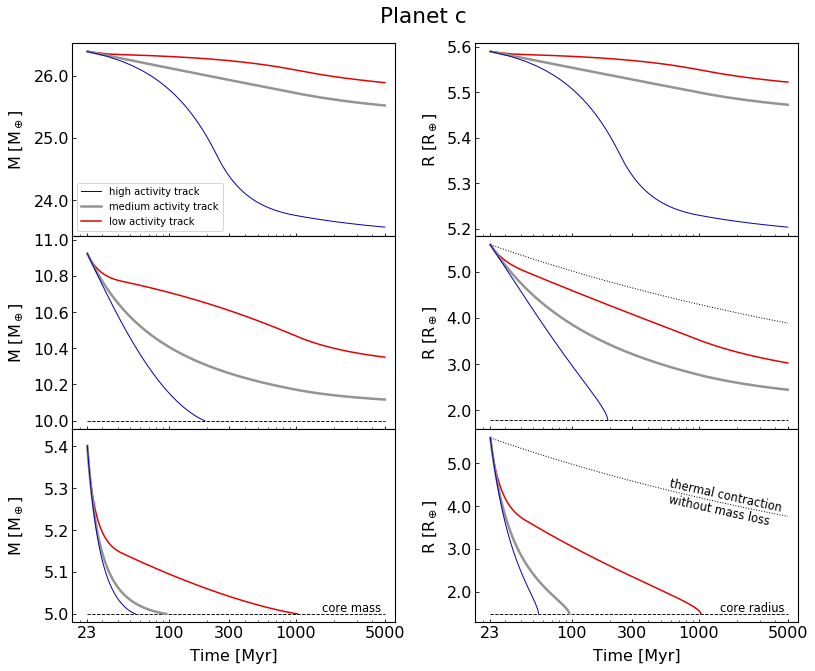

In [38]:
fig, axs = plt.subplots(3,2, figsize=(13,10), sharex=True, sharey=False)

fig.suptitle("Planet c")
#ax1.set_title("Planet c")
fig.subplots_adjust(top=0.93)

# Otegi/heavy
axs[0, 0].plot(t1_c_OtP, (M1_c_OtP), label="high activity track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 0].plot(t2_c_OtP, (M2_c_OtP), label="medium activity track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 0].plot(t3_c_OtP, (M3_c_OtP), label="low activity track", ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 0].plot(t1_c_10P, (M1_c_10P), label=r"fast, step = 0.1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 0].plot(t2_c_10P, (M2_c_10P), label=r"med, step = 0.1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 0].plot(t3_c_10P, (M3_c_10P), label=r"slow, step = 0.1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[1, 0].hlines(pl_c_10_PAPER.core_mass, t1_c_10P[0], 5000., linestyle="--", color="k", lw=0.9)

# 5Mcore
axs[2, 0].plot(t1_c_5P, (M1_c_5P), label=r"fast, step = 0.1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 0].plot(t2_c_5P, (M2_c_5P), label=r"med, step = 0.1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 0].plot(t3_c_5P, (M3_c_5P), label=r"slow, step = 0.1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 0].hlines(pl_c_5_PAPER.core_mass, t1_c_5P[0], 5000., linestyle="--", color="k", lw=0.9)
axs[2, 0].text(1600, 5.006, "core mass", fontsize=11.5)

#radii
# Otegi/heavy
axs[0, 1].plot(t1_c_OtP, (R1_c_OtP), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 1].plot(t2_c_OtP, (R2_c_OtP), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 1].plot(t3_c_OtP, (R3_c_OtP), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 1].plot(t1_c_10P, (R1_c_10P), label=r"fast, step = 0.1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 1].plot(t2_c_10P, (R2_c_10P), label=r"med, step = 0.1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 1].plot(t3_c_10P, (R3_c_10P), label=r"slow, step = 0.1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
age_arr = np.linspace(23., 5000., 1000)
axs[1, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_c_10_PAPER.core_mass, pl_c_10_PAPER.fenv, age_arr, pl_c_10_PAPER.flux, pl_c_10_PAPER.metallicity), color="k", ls=":", lw=1)
axs[1, 1].hlines(plmo14.calculate_core_radius(pl_c_10_PAPER.core_mass), pl_c_10_PAPER.age, 5000., linestyle="--", color="k", lw=0.9)

dy = 1.25
axs[2, 1].text(575, 3.19+dy, "thermal contraction", fontsize=11.5, rotation=-12.5)
axs[2, 1].text(570, 2.82+dy, "without mass loss", fontsize=11.5, rotation=-12.5)
#xkcd:goldenrod

# 5 mcore
axs[2, 1].plot(t1_c_5P, (R1_c_5P), label=r"fast track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 1].plot(t2_c_5P, (R2_c_5P), label=r"medim track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 1].plot(t3_c_5P, (R3_c_5P), label=r"slow track", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_c_5_PAPER.core_mass, pl_c_5_PAPER.fenv, age_arr, pl_c_5_PAPER.flux, pl_c_5_PAPER.metallicity), color="k", ls=":", lw=1)
axs[2, 1].hlines(plmo14.calculate_core_radius(pl_c_5_PAPER.core_mass), pl_c_5_PAPER.age, 5000., linestyle="--", color="k", lw=0.9)
axs[2, 1].text(1475, 1.55, "core radius", fontsize=11.5)

axs[0, 0].legend(fontsize=10, loc=3)
for ax in [axs[0, 0], axs[1, 0], axs[2, 0]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
    ax.tick_params(direction="in", which="both", labelsize=16)
    ax.set_xlabel("Time [Myr]", fontsize=16, labelpad=8)
    ax.set_ylabel('M [M$_\oplus$]', fontsize=16, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places

ylim = axs[2, 0].get_ylim()
axs[2, 0].set_ylim(top=ylim[1]+0.02)
ylim = axs[1, 0].get_ylim()
axs[1, 0].set_ylim(top=11.02)
    
for ax in [axs[0, 1], axs[1, 1], axs[2, 1]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.tick_params(direction="in", which="both", labelsize=16)
    ax.set_xlabel("Time [Myr]", fontsize=16, labelpad=8)
    ax.set_ylabel('R [R$_\oplus$]', fontsize=16, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places

plt.subplots_adjust(hspace=0, wspace=0.25)
fig.align_ylabels(axs[:, 0])
fig.align_ylabels(axs[:, 1])
#plt.tight_layout()
#plt.savefig("./planet_c_EVO_eps01_Zsun.jpg", dpi=300)
plt.show()

### Planet c - larger labels for in-text plot

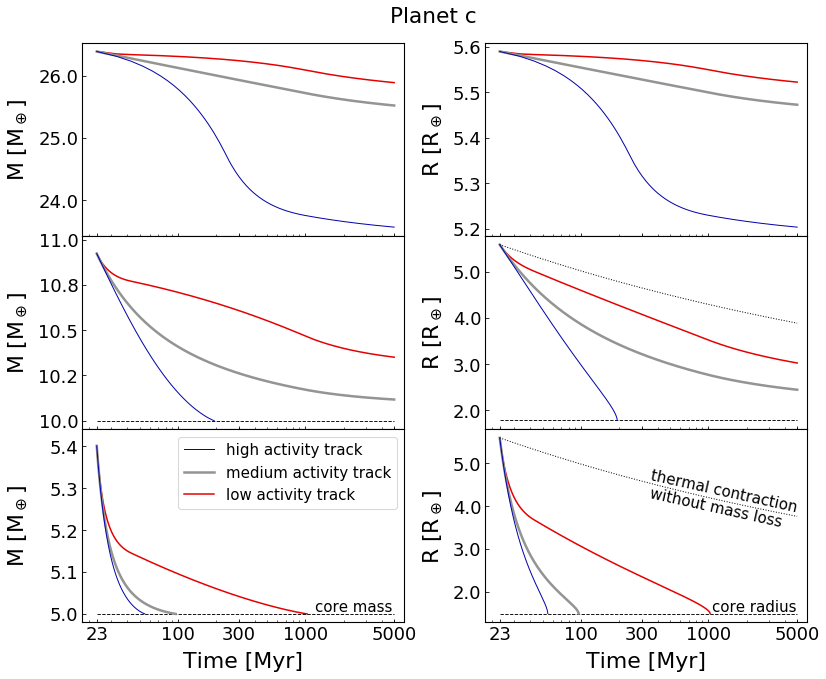

In [39]:
fig, axs = plt.subplots(3,2, figsize=(13,10), sharex=True, sharey=False)
fig.suptitle("Planet c")
fig.subplots_adjust(top=0.93)

# Otegi/heavy
axs[0, 0].plot(t1_c_OtP, (M1_c_OtP), label="high activity track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 0].plot(t2_c_OtP, (M2_c_OtP), label="medium activity track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 0].plot(t3_c_OtP, (M3_c_OtP), label="low activity track", ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 0].plot(t1_c_10P, (M1_c_10P), label=r"fast, step = 0.1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 0].plot(t2_c_10P, (M2_c_10P), label=r"med, step = 0.1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 0].plot(t3_c_10P, (M3_c_10P), label=r"slow, step = 0.1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[1, 0].hlines(pl_c_10_PAPER.core_mass, t1_c_10P[0], 5000., linestyle="--", color="k", lw=0.9)

# 5Mcore
axs[2, 0].plot(t1_c_5P, (M1_c_5P), label=r"high activity track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 0].plot(t2_c_5P, (M2_c_5P), label=r"medium activity track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 0].plot(t3_c_5P, (M3_c_5P), label=r"low activity track", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 0].hlines(pl_c_5_PAPER.core_mass, t1_c_5P[0], 5000., linestyle="--", color="k", lw=0.9)
axs[2, 0].text(1200, 5.006, "core mass", fontsize=15)

#radii
# Otegi/heavy
axs[0, 1].plot(t1_c_OtP, (R1_c_OtP), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 1].plot(t2_c_OtP, (R2_c_OtP), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 1].plot(t3_c_OtP, (R3_c_OtP), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 1].plot(t1_c_10P, (R1_c_10P), label=r"fast, step = 0.1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 1].plot(t2_c_10P, (R2_c_10P), label=r"med, step = 0.1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 1].plot(t3_c_10P, (R3_c_10P), label=r"slow, step = 0.1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
age_arr = np.linspace(23., 5000., 1000)
axs[1, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_c_10_PAPER.core_mass, pl_c_10_PAPER.fenv, age_arr, pl_c_10_PAPER.flux, pl_c_10_PAPER.metallicity), color="k", ls=":", lw=1)
axs[1, 1].hlines(plmo14.calculate_core_radius(pl_c_10_PAPER.core_mass), pl_c_10_PAPER.age, 5000., linestyle="--", color="k", lw=0.9)

dy = 1.3
axs[2, 1].text(345, 3.31+dy, "thermal contraction", fontsize=15, rotation=-12.5)
axs[2, 1].text(340, 2.9+dy, "without mass loss", fontsize=15, rotation=-12.5)
#xkcd:goldenrod

# 5 mcore
axs[2, 1].plot(t1_c_5P, (R1_c_5P), label=r"fast track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 1].plot(t2_c_5P, (R2_c_5P), label=r"medim track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 1].plot(t3_c_5P, (R3_c_5P), label=r"slow track", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_c_5_PAPER.core_mass, pl_c_5_PAPER.fenv, age_arr, pl_c_5_PAPER.flux, pl_c_5_PAPER.metallicity), color="k", ls=":", lw=1)
axs[2, 1].hlines(plmo14.calculate_core_radius(pl_c_5_PAPER.core_mass), pl_c_5_PAPER.age, 5000., linestyle="--", color="k", lw=0.9)
axs[2, 1].text(1075, 1.55, "core radius", fontsize=15)

axs[2, 0].legend(fontsize=15)#, loc=3)
for ax in [axs[0, 0], axs[1, 0], axs[2, 0]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
    ax.tick_params(direction="in", which="both", labelsize=18)
    ax.set_xlabel("Time [Myr]", fontsize=22, labelpad=8)
    ax.set_ylabel('M [M$_\oplus$]', fontsize=22, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places

ylim = axs[2, 0].get_ylim()
axs[2, 0].set_ylim(top=ylim[1]+0.02)
ylim = axs[1, 0].get_ylim()
axs[1, 0].set_ylim(top=11.02)
    
for ax in [axs[0, 1], axs[1, 1], axs[2, 1]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.tick_params(direction="in", which="both", labelsize=18)
    ax.set_xlabel("Time [Myr]", fontsize=22, labelpad=8)
    ax.set_ylabel('R [R$_\oplus$]', fontsize=22, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places

plt.subplots_adjust(hspace=0, wspace=0.25)
fig.align_ylabels(axs[:, 0])
fig.align_ylabels(axs[:, 1])
#plt.tight_layout()
#plt.savefig("./Plots_PAPER/planet_c_EVO_eps01_Zsun_largelabels.jpg", dpi=300)
#plt.savefig("./Plots_PAPER/Fig9_largelabels.jpg", dpi=300)
plt.show()

## Plot mass & radius evolution planet d

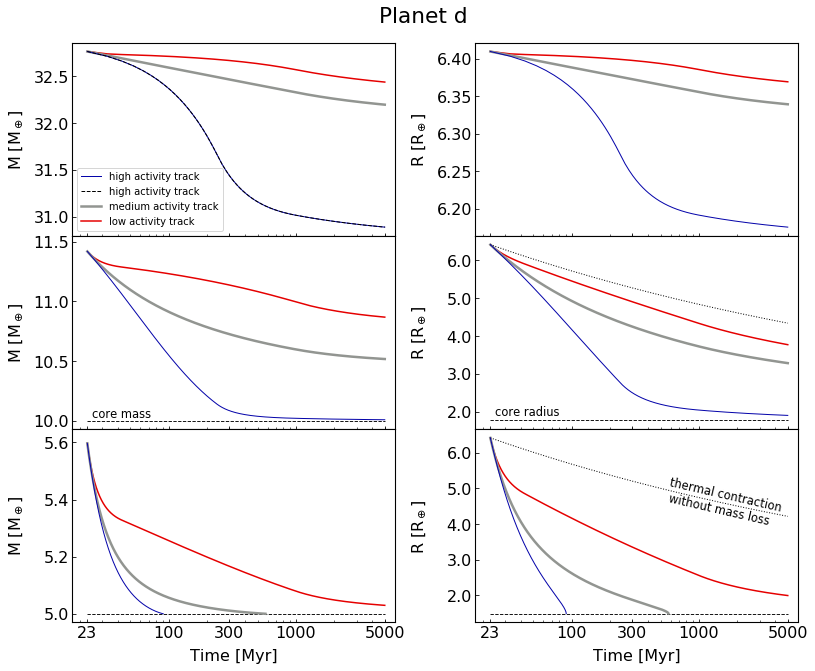

In [42]:
fig, axs = plt.subplots(3,2, figsize=(13,10), sharex=True, sharey=False)

fig.suptitle("Planet d")
#ax1.set_title("Planet c")
fig.subplots_adjust(top=0.93)

# Otegi/heavy
axs[0, 0].plot(t1_d_OtP, (M1_d_OtP), label="high activity track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 0].plot(t2_d_OtP, (M2_d_OtP), label="medium activity track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 0].plot(t3_d_OtP, (M3_d_OtP), label="low activity track", ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 0].plot(t1_d_10P, (M1_d_10P), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 0].plot(t2_d_10P, (M2_d_10P), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 0].plot(t3_d_10P, (M3_d_10P), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[1, 0].hlines(pl_d_10_PAPER.core_mass, t1_d_10P[0], 5000., linestyle="--", color="k", lw=0.9)
axs[1, 0].text(25, 10.025, "core mass", fontsize=11.5)

# 5Mcore
axs[2, 0].plot(t1_d_5P, (M1_d_5P), label=r"fast, step = 0.1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 0].plot(t2_d_5P, (M2_d_5P), label=r"med, step = 0.1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 0].plot(t3_d_5P, (M3_d_5P), label=r"slow, step = 0.1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 0].hlines(pl_d_5_PAPER.core_mass, t1_d_5P[0], 5000., linestyle="--", color="k", lw=0.9)

#radii
# Otegi/heavy
axs[0, 1].plot(t1_d_OtP, (R1_d_OtP), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 1].plot(t2_d_OtP, (R2_d_OtP), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 1].plot(t3_d_OtP, (R3_d_OtP), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 1].plot(t1_d_10P, (R1_d_10P), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 1].plot(t2_d_10P, (R2_d_10P), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 1].plot(t3_d_10P, (R3_d_10P), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
age_arr = np.linspace(23., 5000., 1000)
axs[1, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_d_10_PAPER.core_mass, pl_d_10_PAPER.fenv, age_arr, pl_d_10_PAPER.flux, pl_d_10_PAPER.metallicity), color="k", ls=":", lw=1)
axs[1, 1].hlines(plmo14.calculate_core_radius(pl_d_10_PAPER.core_mass), pl_d_10_PAPER.age, 5000., linestyle="--", color="k", lw=0.9)
axs[1, 1].text(25, 1.9, "core radius", fontsize=11.5)

# 5 mcore
axs[2, 1].plot(t1_d_5P, (R1_d_5P), label=r"fast track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 1].plot(t2_d_5P, (R2_d_5P), label=r"medim track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 1].plot(t3_d_5P, (R3_d_5P), label=r"slow track", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_d_5_PAPER.core_mass, pl_d_5_PAPER.fenv, age_arr, pl_d_5_PAPER.flux, pl_d_5_PAPER.metallicity), color="k", ls=":", lw=1)
axs[2, 1].hlines(plmo14.calculate_core_radius(pl_d_5_PAPER.core_mass), pl_d_5_PAPER.age, 5000., linestyle="--", color="k", lw=0.9)
dy = 1.82
axs[2, 1].text(575, 3.25+dy, "thermal contraction", fontsize=11.5, rotation=-13)
axs[2, 1].text(570, 2.8+dy, "without mass loss", fontsize=11.5, rotation=-13)

axs[0, 0].legend(fontsize=10, loc=3)
for ax in [axs[0, 0], axs[1, 0], axs[2, 0]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
    ax.tick_params(direction="in", which="both", labelsize=16)
    ax.set_xlabel("Time [Myr]", fontsize=16, labelpad=8)
    ax.set_ylabel('M [M$_\oplus$]', fontsize=16, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places

ylim = axs[2, 0].get_ylim()
axs[2, 0].set_ylim(top=ylim[1]+0.02)
ylim = axs[1, 0].get_ylim()
axs[1, 0].set_ylim(top=11.55)
    
for ax in [axs[0, 1], axs[1, 1], axs[2, 1]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.tick_params(direction="in", which="both", labelsize=16)
    ax.set_xlabel("Time [Myr]", fontsize=16, labelpad=8)
    ax.set_ylabel('R [R$_\oplus$]', fontsize=16, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places

axs[0,1].yaxis.set_major_formatter(FormatStrFormatter('%.2f')) # No decimal places
plt.subplots_adjust(hspace=0, wspace=0.25)
fig.align_ylabels(axs[:, 0])
fig.align_ylabels(axs[:, 1])
#plt.tight_layout()
#plt.savefig("./planet_d_EVO_eps01_Zsun.jpg", dpi=300)
plt.show()

### Planet d - larger labels for in-text plot

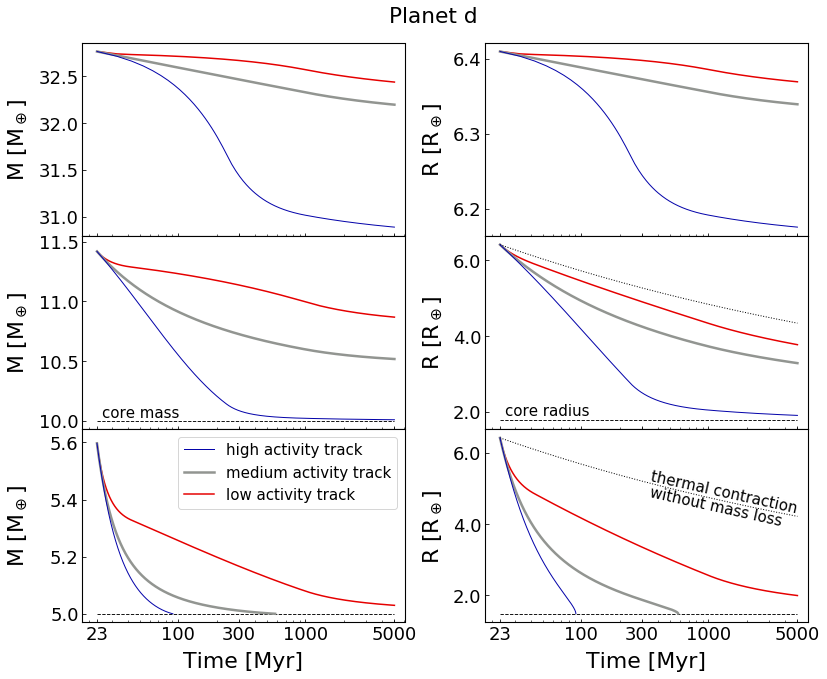

In [43]:
fig, axs = plt.subplots(3,2, figsize=(13,10), sharex=True, sharey=False)
fig.suptitle("Planet d")
fig.subplots_adjust(top=0.93)

# Otegi/heavy
axs[0, 0].plot(t1_d_OtP, (M1_d_OtP), label="high activity track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 0].plot(t2_d_OtP, (M2_d_OtP), label="medium activity track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 0].plot(t3_d_OtP, (M3_d_OtP), label="low activity track", ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 0].plot(t1_d_10P, (M1_d_10P), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 0].plot(t2_d_10P, (M2_d_10P), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 0].plot(t3_d_10P, (M3_d_10P), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[1, 0].hlines(pl_d_10_PAPER.core_mass, t1_d_10P[0], 5000., linestyle="--", color="k", lw=0.9)
axs[1, 0].text(25, 10.025, "core mass", fontsize=15)

# 5Mcore
axs[2, 0].plot(t1_d_5P, (M1_d_5P), label=r"high activity track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 0].plot(t2_d_5P, (M2_d_5P), label=r"medium activity track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 0].plot(t3_d_5P, (M3_d_5P), label=r"low activity track", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 0].hlines(pl_d_5_PAPER.core_mass, t1_d_5P[0], 5000., linestyle="--", color="k", lw=0.9)

#radii
# Otegi/heavy
axs[0, 1].plot(t1_d_OtP, (R1_d_OtP), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 1].plot(t2_d_OtP, (R2_d_OtP), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 1].plot(t3_d_OtP, (R3_d_OtP), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 1].plot(t1_d_10P, (R1_d_10P), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 1].plot(t2_d_10P, (R2_d_10P), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 1].plot(t3_d_10P, (R3_d_10P), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
age_arr = np.linspace(23., 5000., 1000)
axs[1, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_d_10_PAPER.core_mass, pl_d_10_PAPER.fenv, age_arr, pl_d_10_PAPER.flux, pl_d_10_PAPER.metallicity), color="k", ls=":", lw=1)
axs[1, 1].hlines(plmo14.calculate_core_radius(pl_d_10_PAPER.core_mass), pl_d_10_PAPER.age, 5000., linestyle="--", color="k", lw=0.9)
axs[1, 1].text(25, 1.9, "core radius", fontsize=15)

# 5 mcore
axs[2, 1].plot(t1_d_5P, (R1_d_5P), label=r"high activity track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 1].plot(t2_d_5P, (R2_d_5P), label=r"medium activity track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 1].plot(t3_d_5P, (R3_d_5P), label=r"low activity track", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_d_5_PAPER.core_mass, pl_d_5_PAPER.fenv, age_arr, pl_d_5_PAPER.flux, pl_d_5_PAPER.metallicity), color="k", ls=":", lw=1)
axs[2, 1].hlines(plmo14.calculate_core_radius(pl_d_5_PAPER.core_mass), pl_d_5_PAPER.age, 5000., linestyle="--", color="k", lw=0.9)

dy = 1.88
axs[2, 1].text(345, 3.33+dy, "thermal contraction", fontsize=15, rotation=-12.5)
axs[2, 1].text(340, 2.87+dy, "without mass loss", fontsize=15, rotation=-12.5)

axs[2, 0].legend(fontsize=15)
for ax in [axs[0, 0], axs[1, 0], axs[2, 0]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
    ax.tick_params(direction="in", which="both", labelsize=18)
    ax.set_xlabel("Time [Myr]", fontsize=22, labelpad=8)
    ax.set_ylabel('M [M$_\oplus$]', fontsize=22, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places

ylim = axs[2, 0].get_ylim()
axs[2, 0].set_ylim(top=ylim[1]+0.02)
ylim = axs[1, 0].get_ylim()
axs[1, 0].set_ylim(top=11.55)
    
for ax in [axs[0, 1], axs[1, 1], axs[2, 1]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.tick_params(direction="in", which="both", labelsize=18)
    ax.set_xlabel("Time [Myr]", fontsize=22, labelpad=8)
    ax.set_ylabel('R [R$_\oplus$]', fontsize=22, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places

axs[0,1].yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places
plt.subplots_adjust(hspace=0, wspace=0.25)
fig.align_ylabels(axs[:, 0])
fig.align_ylabels(axs[:, 1])
#plt.tight_layout()
#plt.savefig("./Plots_PAPER/planet_d_EVO_eps01_Zsun_largelabels.jpg", dpi=300)
#plt.savefig("./Plots_PAPER/Fig10_largelabels.jpg", dpi=300)
plt.show()

## Plot mass & radius evolution planet b

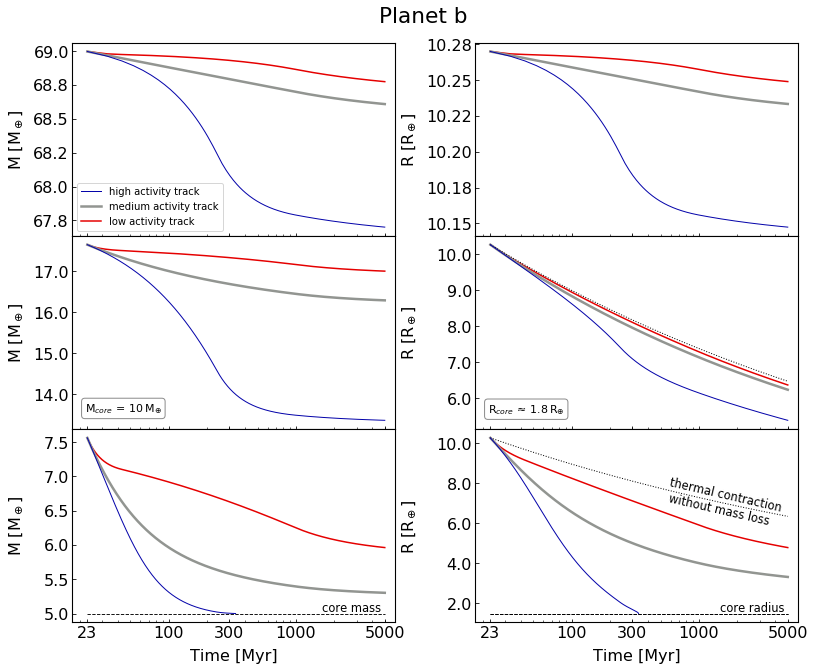

In [44]:
fig, axs = plt.subplots(3,2, figsize=(13,10), sharex=True, sharey=False)
fig.suptitle("Planet b")
fig.subplots_adjust(top=0.93)

# Otegi/heavy
axs[0, 0].plot(t1_b_OtP, (M1_b_OtP), label="high activity track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 0].plot(t2_b_OtP, (M2_b_OtP), label="medium activity track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 0].plot(t3_b_OtP, (M3_b_OtP), label="low activity track", ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 0].plot(t1_b_10P, (M1_b_10P), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 0].plot(t2_b_10P, (M2_b_10P), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 0].plot(t3_b_10P, (M3_b_10P), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
#axs[1, 0].hlines(M_core10/MEc, t1_b_10[0], 5000., ls="--", color="k", lw=0.9)
#axs[1, 0].text(25, 10.025, "core mass", fontsize=11.5)

# 5Mcore
axs[2, 0].plot(t1_b_5P, (M1_b_5P), label=r"fast, step = 0.1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 0].plot(t2_b_5P, (M2_b_5P), label=r"med, step = 0.1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 0].plot(t3_b_5P, (M3_b_5P), label=r"slow, step = 0.1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 0].hlines(pl_b_5_PAPER.core_mass, t1_b_5P[0], 5000., linestyle="--", color="k", lw=0.9)
axs[2, 0].text(1600, 5.03, "core mass", fontsize=11.5)

#radii
# Otegi/heavy
axs[0, 1].plot(t1_b_OtP, (R1_b_OtP), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 1].plot(t2_b_OtP, (R2_b_OtP), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 1].plot(t3_b_OtP, (R3_b_OtP), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 1].plot(t1_b_10P, (R1_b_10P), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 1].plot(t2_b_10P, (R2_b_10P), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 1].plot(t3_b_10P, (R3_b_10P), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
age_arr = np.linspace(23., 5000., 1000)
axs[1, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_b_10_PAPER.core_mass, pl_b_10_PAPER.fenv, age_arr, pl_b_10_PAPER.flux, pl_b_10_PAPER.metallicity), color="k", ls=":", lw=1)

# 5 mcore
axs[2, 1].plot(t1_b_5P, (R1_b_5P), label=r"fast track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 1].plot(t2_b_5P, (R2_b_5P), label=r"medim track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 1].plot(t3_b_5P, (R3_b_5P), label=r"slow track", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_b_5_PAPER.core_mass, pl_b_5_PAPER.fenv, age_arr, pl_b_5_PAPER.flux, pl_b_5_PAPER.metallicity), color="k", ls=":", lw=1)
axs[2, 1].hlines(plmo14.calculate_core_radius(pl_b_5_PAPER.core_mass), pl_d_5_PAPER.age, 5000., linestyle="--", color="k", lw=0.9)
dy = 4.27
axs[2, 1].text(575, 3.6+dy, "thermal contraction", fontsize=11.5, rotation=-13)
axs[2, 1].text(570, 2.8+dy, "without mass loss", fontsize=11.5, rotation=-13)
axs[2, 1].hlines(plmo14.calculate_core_radius(pl_b_5_PAPER.core_mass), t1_b_5P[0], 5000., linestyle="--", color="k", lw=0.9)
axs[2, 1].text(1475, 1.62, "core radius", fontsize=11.5)

# box with core & radius for 10Mcore planet
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
axs[1, 0].text(22, 13.65, r"M$_{core}\,=\,10\,$M$_{\oplus}$", va="center", size=11, bbox=bbox_props)
axs[1, 1].text(22, 5.7, r"R$_{core}\,\approx\,1.8\,$R$_{\oplus}$", va="center", size=11, bbox=bbox_props)

axs[0, 0].legend(fontsize=10, loc=3)
for ax in [axs[0, 0], axs[1, 0], axs[2, 0]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
    ax.tick_params(direction="in", which="both", labelsize=16)
    ax.set_xlabel("Time [Myr]", fontsize=16, labelpad=8)
    ax.set_ylabel('M [M$_\oplus$]', fontsize=16, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places

for ax in [axs[0, 1], axs[1, 1], axs[2, 1]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.tick_params(direction="in", which="both", labelsize=16)
    ax.set_xlabel("Time [Myr]", fontsize=16, labelpad=8)
    ax.set_ylabel('R [R$_\oplus$]', fontsize=16, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places
    
axs[0,1].yaxis.set_major_formatter(FormatStrFormatter('%.2f')) # No decimal places
plt.subplots_adjust(hspace=0, wspace=0.25)
fig.align_ylabels(axs[:, 0])
fig.align_ylabels(axs[:, 1])
#plt.tight_layout()
#plt.savefig("./planet_b_EVO_eps01_Zsun.jpg", dpi=300)
plt.show()

## Plot mass & radius evolution planet e

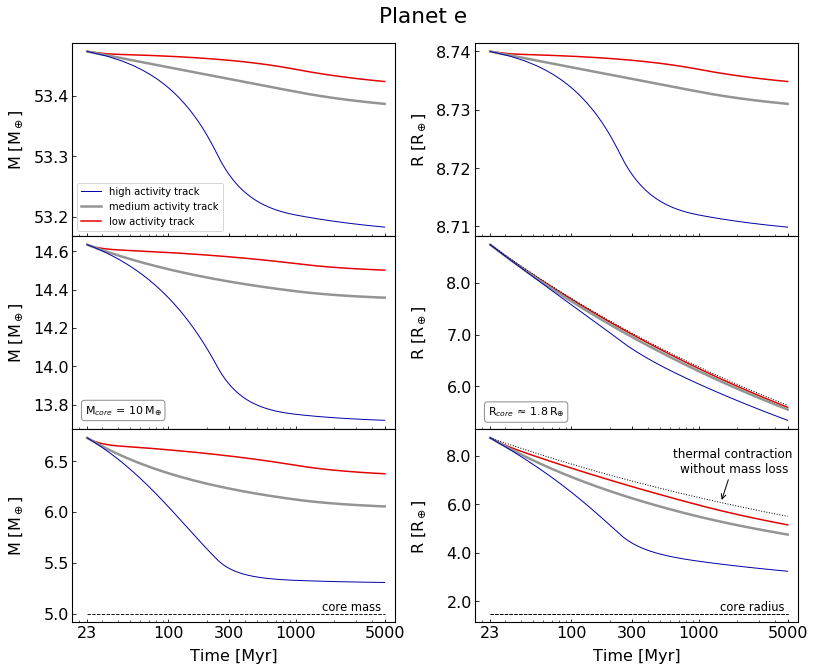

In [45]:
fig, axs = plt.subplots(3,2, figsize=(13,10), sharex=True, sharey=False)
fig.suptitle("Planet e")
fig.subplots_adjust(top=0.93)

# Otegi/heavy
axs[0, 0].plot(t1_e_OtP, (M1_e_OtP), label="high activity track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 0].plot(t2_e_OtP, (M2_e_OtP), label="medium activity track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 0].plot(t3_e_OtP, (M3_e_OtP), label="low activity track", ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 0].plot(t1_e_10P, (M1_e_10P), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 0].plot(t2_e_10P, (M2_e_10P), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 0].plot(t3_e_10P, (M3_e_10P), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
#axs[1, 0].hlines(M_core10/MEc, t1_e_10[0], 5000., ls="--", color="k", lw=0.9)
#axs[1, 0].text(25, 10.025, "core mass", fontsize=11.5)

# 5Mcore
axs[2, 0].plot(t1_e_5P, (M1_e_5P), label=r"fast, step = 0.1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 0].plot(t2_e_5P, (M2_e_5P), label=r"med, step = 0.1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 0].plot(t3_e_5P, (M3_e_5P), label=r"slow, step = 0.1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 0].hlines(pl_e_5_PAPER.core_mass, t1_e_5P[0], 5000., linestyle="--", color="k", lw=0.9)
axs[2, 0].text(1600, 5.03, "core mass", fontsize=11.5)

#radii
# Otegi/heavy
axs[0, 1].plot(t1_e_OtP, (R1_e_OtP), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 1].plot(t2_e_OtP, (R2_e_OtP), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 1].plot(t3_e_OtP, (R3_e_OtP), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 1].plot(t1_e_10P, (R1_e_10P), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 1].plot(t2_e_10P, (R2_e_10P), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 1].plot(t3_e_10P, (R3_e_10P), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
age_arr = np.linspace(23., 5000., 1000)
axs[1, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_e_10_PAPER.core_mass, pl_e_10_PAPER.fenv, age_arr, pl_e_10_PAPER.flux, pl_e_10_PAPER.metallicity), color="k", ls=":", lw=1)

# 5 mcore
axs[2, 1].plot(t1_e_5P, (R1_e_5P), label=r"fast track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 1].plot(t2_e_5P, (R2_e_5P), label=r"medim track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 1].plot(t3_e_5P, (R3_e_5P), label=r"slow track", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_e_5_PAPER.core_mass, pl_e_5_PAPER.fenv, age_arr, pl_e_5_PAPER.flux, pl_e_5_PAPER.metallicity), color="k", ls=":", lw=1)
axs[2, 1].hlines(plmo14.calculate_core_radius(pl_e_5_PAPER.core_mass), pl_e_5_PAPER.age, 5000., linestyle="--", color="k", lw=0.9)
dy = 2.6
axs[2, 1].annotate('thermal contraction \nwithout mass loss', xy=(1500, 3.5+dy), xytext=(1900, 7.3), fontsize=12, ha='center',
            arrowprops=dict(arrowstyle="->"))
axs[2, 1].hlines(plmo14.calculate_core_radius(pl_e_5_PAPER.core_mass), t1_e_5P[0], 5000., linestyle="--", color="k", lw=0.9)
axs[2, 1].text(1475, 1.62, "core radius", fontsize=11.5)

# box with core & radius for 10Mcore planet
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
axs[1, 0].text(22, 13.77, r"M$_{core}\,=\,10\,$M$_{\oplus}$", va="center", size=11, bbox=bbox_props)
axs[1, 1].text(22, 5.5, r"R$_{core}\,\approx\,1.8\,$R$_{\oplus}$", va="center", size=11, bbox=bbox_props)

axs[0, 0].legend(fontsize=10, loc=3)
for ax in [axs[0, 0], axs[1, 0], axs[2, 0]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
    ax.tick_params(direction="in", which="both", labelsize=16)
    ax.set_xlabel("Time [Myr]", fontsize=16, labelpad=8)
    ax.set_ylabel('M [M$_\oplus$]', fontsize=16, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places
    
for ax in [axs[0, 1], axs[1, 1], axs[2, 1]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.tick_params(direction="in", which="both", labelsize=16)
    ax.set_xlabel("Time [Myr]", fontsize=16, labelpad=8)
    ax.set_ylabel('R [R$_\oplus$]', fontsize=16, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places
    
axs[0,1].yaxis.set_major_formatter(FormatStrFormatter('%.2f')) # No decimal places
plt.subplots_adjust(hspace=0, wspace=0.25)
fig.align_ylabels(axs[:, 0])
fig.align_ylabels(axs[:, 1])
#plt.tight_layout()
#plt.savefig("./planet_e_EVO_eps01_Zsun.jpg", dpi=300)
plt.show()

## Evolution of planets in the Radius-Period diagram

In [46]:
# Instantiate exoplanetEU2 object (download all the planets)
v = pyasl.ExoplanetEU2()
# Export all data as a pandas DataFrame
planets = v.getAllDataPandas()
planets_masses = planets[~np.isnan(planets["mass"])]

mask_nan = ~(np.isnan(planets["orbital_period"]) | np.isnan(planets["radius"]))
mask_P = planets["orbital_period"]<300
planets_ = planets[mask_nan & mask_P] # dataframe only with planets which have P & R

R_to_earth = 11.2
period = planets_["orbital_period"].values
radius = planets_["radius"].values*R_to_earth
ds = planets_["semi_major_axis"].values

# actual data -> transform to log space
log3P = np.log(period)/np.log(3)
log2R = np.log(radius)/np.log(2)

### Gaussian kernel density estimation

In [49]:
# actual data -> transform to log space
log3P = np.log(period)/np.log(3)
log2R = np.log(radius)/np.log(2)

# make a grid (in log space - to match the data)
n = np.arange(log3P.min(),log3P.max()+1,1)
m = np.arange(log2R.min(),log2R.max()+1,1)
nn, mm = np.mgrid[n.min():n.max():200j, m.min():m.max():200j] 

nm_sample = np.vstack([nn.ravel(), mm.ravel()]).T # now I have a grid of points covering my radii and periods
nm_train  = np.vstack([log3P, log2R]).T # this is my data in grid-form

# d = nm_sample.shape[0]
# n = nm_sample.shape[1]
# bandwidth = (n * (d + 2) / 4.)**(-1. / (d + 4)) # silverman
# print(bandwidth)

# construct a Gaussian kernel density estimate of the distribution
kde = KernelDensity(bandwidth=0.25, kernel='gaussian')
kde.fit(nm_train) # fit/load real dataset

# score_samples() returns the log-likelihood of the samples
prob_density = np.exp(kde.score_samples(nm_sample))
# nm_sample is the range/grid over which I compute the density based on the data (2-D)
prob_density = np.reshape(prob_density, nn.shape)

In [50]:
# V1298 Tau Planets
P_c = 8.24958 # days
#P_c_err = abs(np.array([[-0.00072], [+0.00072]]))
P_d = 12.4032
#P_d_err = abs(np.array([[-0.0015], [+0.0015]]))
P_b = 24.1396
#P_b_err = abs(np.array([[-0.0018], [+0.0018]]))
P_e = 60
#P_e_err = abs(np.array([[-18], [+60]]))

## Evolution of planet in Radius-Period diagram

In [76]:
star_V1298Tau["age"] = 5000.

In [80]:
age_5Gyr = 5000.
star_V1298Tau["age"] = age_5Gyr
planet_c = {"core_mass": 5.0, "fenv": 21.46122186655056, "distance": a_c, "metallicity": "solarZ"}
planet_LoFo14(star_V1298Tau, planet_c).radius

#planet_d = {"core_mass": 5.0, "radius": R_d, "distance": a_d, "metallicity": "solarZ"}
#planet_b = {"core_mass": 5.0, "radius": R_b, "distance": a_b, "metallicity": "solarZ"}
#planet_e = {"core_mass": 5.0, "radius": R_e, "distance": a_e, "metallicity": "solarZ"}



5.589999999999961

NameError: name 'calculate_planet_radius_solarZ' is not defined

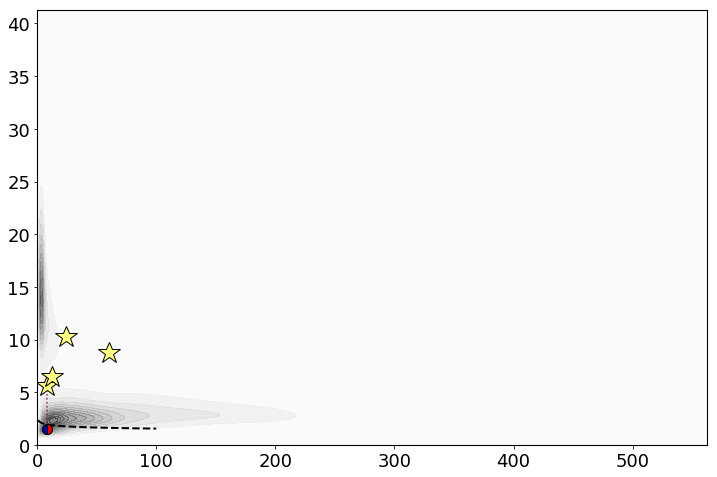

In [61]:
fig, ax = plt.subplots(figsize=(12,8))

# plot gaussian kernel density of known exoplanet population
ax.contourf(3**nn, 2**mm, prob_density, cmap="binary", levels=15, alpha=0.5)
#plt.plot(log3P, log2R, marker=".", ls="None", alpha=0.1, c="r") # actual data points (before smoothing)

#period-radius evaporation valley (van Eylen)
p6, = plt.plot(np.linspace(1,100,100), 10**(-0.09*np.log10(np.linspace(1,100,100))+0.37), linestyle='--', lw=2, color='xkcd:black', label='Evaporation valley \n(Van Eylen et al. 2018)')

ax.plot(P_c, R_c, marker="*", color="xkcd:pale yellow", mec="black", ms=23)
ax.plot(P_d, R_d, marker="*", color="xkcd:pale yellow", mec="black", ms=23)
ax.plot(P_b, R_b, marker="*", color="xkcd:pale yellow", mec="black", ms=23)
ax.plot(P_e, R_e, marker="*", color="xkcd:pale yellow", mec="black", ms=23)

# plot planetary evolution tracks
# draw mark where final radius after thermal contraction without mass loss is as black triangle!
######################################################################################################################################
# planet c
# M_core = 5
mspp = 4 # marker size of thermal evo marker
mspp_5 = 10 # marker size of planet positions (5coremass)
mspp_10 = 8 # marker size of planet positions (5coremass)
dP = 0.3

ax.plot(P_c-dP, R1_c_5[-1], color="xkcd:royal blue", alpha=1, marker="o", ms=mspp_5, mew=1, mec="xkcd:black")#marker="x", markersize=10, fillstyle="none", markeredgewidth=2.5)
ax.vlines(P_c-dP, R1_c_5[0], R1_c_5[-1], color="xkcd:royal blue", linestyle=":", alpha=0.5)
#ax.plot(P_c-dP, R2_c_5[-1], color="xkcd:grey", alpha=1, marker="o", ms=mspp_5, mew=1, mec="xkcd:black", fillstyle="left")
ax.plot(P_c-dP, R3_c_5[-1], color="xkcd:red", alpha=1, marker="o", ms=mspp_5, mew=1, mec="xkcd:black", fillstyle="right")#marker="x", markersize=10, fillstyle="none", markeredgewidth=2.5)
ax.vlines(P_c-dP, R_c, R3_c_5[-1], color="xkcd:red", linestyle=":", alpha=0.5)
# final radius with thermal contraction only
ax.plot(P_c-dP, calculate_planet_radius(pl_b_5.core_mass, pl_b_5.fenv, age_5Gyr, pl_b_5.flux), 
        color="xkcd:black", ls="None", marker="^", ms=mspp, mew=2, mec="xkcd:black", alpha=1)


# # M_core = 10
# dP = -0.35
# ax.plot(P_c-dP, (M_core10/MEc)**0.25 if np.isnan(R1_c_01_10Mcore_Zsun_on).any() else R1_c_01_10Mcore_Zsun_on[-1]/RE, 
#         color="xkcd:royal blue", alpha=1, marker="s", ms=mspp_10, mew=1, mec="xkcd:black")#marker="x", markersize=10, fillstyle="none", markeredgewidth=2.5)
# ax.vlines(P_c-dP, R_c, (M_core10/MEc)**0.25 if np.isnan(R1_c_01_10Mcore_Zsun_on).any() else R1_c_01_10Mcore_Zsun_on[-1]/RE, color="xkcd:royal blue", ls=":", alpha=0.5)

# ax.plot(P_c-dP, (M_core10/MEc)**0.25 if np.isnan(R2_c_01_10Mcore_Zsun_on).any() else R2_c_01_10Mcore_Zsun_on[-1]/RE, 
#         color="xkcd:grey", alpha=1, marker="s", ms=mspp_10, mew=1, mec="xkcd:black")

# ax.plot(P_c-dP, (M_core10/MEc)**0.25 if np.isnan(R3_c_01_10Mcore_Zsun_on).any() else R3_c_01_10Mcore_Zsun_on[-1]/RE, 
#         color="xkcd:red", alpha=1, marker="s", ms=mspp_10, mew=1, mec="xkcd:black")#marker="x", markersize=10, fillstyle="none", markeredgewidth=2.5)
# ax.vlines(P_c-dP, R_c, (M_core10/MEc)**0.25 if np.isnan(R3_c_01_10Mcore_Zsun_on).any() else R3_c_01_10Mcore_Zsun_on[-1]/RE, color="xkcd:red", ls=":", alpha=0.5)
     
# ax.plot(P_c-dP, calculate_planet_radius_solarZ(M_core10, f_env_c_10core_Zsun, age_5Gyr, flux_c_solar)/REc, 
#         color="xkcd:black", ls="None", marker="^", ms=mspp, mew=2, mec="xkcd:black", alpha=1)

# ######################################################################################################################################
# # planet d
# # M_core = 5
# dP = 0.5
# ax.plot(P_d-dP, (M_core5/MEc)**0.25 if np.isnan(R1_d_01_5Mcore_Zsun_on).any() else R1_d_01_5Mcore_Zsun_on[-1]/RE, 
#         color="xkcd:royal blue", alpha=1, marker="o", ms=mspp_5, mew=1, mec="xkcd:black")#marker="x", markersize=10, fillstyle="none", markeredgewidth=2.5)
# ax.vlines(P_d-dP, R_d, (M_core5/MEc)**0.25 if np.isnan(R1_d_01_5Mcore_Zsun_on).any() else R1_d_01_5Mcore_Zsun_on[-1]/RE, color="xkcd:royal blue", ls=":", alpha=0.5)

# ax.plot(P_d-dP, (M_core5/MEc)**0.25 if np.isnan(R2_d_01_5Mcore_Zsun_on).any() else R2_d_01_5Mcore_Zsun_on[-1]/RE, 
#         color="xkcd:grey", alpha=1, marker="o", ms=mspp_5, mew=1, mec="xkcd:black", fillstyle="right")

# ax.plot(P_d-dP, (M_core5/MEc)**0.25 if np.isnan(R3_d_01_5Mcore_Zsun_on).any() else R3_d_01_5Mcore_Zsun_on[-1]/RE, 
#         color="xkcd:red", alpha=1, marker="o", ms=mspp_5, mew=1, mec="xkcd:black")#marker="x", markersize=10, fillstyle="none", markeredgewidth=2.5)
# ax.vlines(P_d-dP, R_d, (M_core5/MEc)**0.25 if np.isnan(R3_d_01_5Mcore_Zsun_on).any() else R3_d_01_5Mcore_Zsun_on[-1]/RE, color="xkcd:red", ls=":", alpha=0.5)
     
# ax.plot(P_d-dP, calculate_planet_radius_solarZ(M_core5, f_env_d_5core_Zsun, age_5Gyr, flux_d_solar)/REc, 
#         color="xkcd:black", ls="None", marker="^", ms=mspp, mew=2, mec="xkcd:black", alpha=1)

# # M_core = 10
# dP = -0.5
# ax.plot(P_d-dP, (M_core10/MEc)**0.25 if np.isnan(R1_d_01_10Mcore_Zsun_on).any() else R1_d_01_10Mcore_Zsun_on[-1]/RE, 
#         color="xkcd:royal blue", alpha=1, marker="s", ms=mspp_10, mew=1, mec="xkcd:black")#marker="x", markersize=10, fillstyle="none", markeredgewidth=2.5)
# ax.vlines(P_d-dP, R_d, (M_core10/MEc)**0.25 if np.isnan(R1_d_01_10Mcore_Zsun_on).any() else R1_d_01_10Mcore_Zsun_on[-1]/RE, color="xkcd:royal blue", ls=":", alpha=0.5)

# ax.plot(P_d-dP, (M_core10/MEc)**0.25 if np.isnan(R2_d_01_10Mcore_Zsun_on).any() else R2_d_01_10Mcore_Zsun_on[-1]/RE, 
#         color="xkcd:grey", alpha=1, marker="s", ms=mspp_10, mew=1, mec="xkcd:black")

# ax.plot(P_d-dP, (M_core10/MEc)**0.25 if np.isnan(R3_d_01_10Mcore_Zsun_on).any() else R3_d_01_10Mcore_Zsun_on[-1]/RE, 
#         color="xkcd:red", alpha=1, marker="s", ms=mspp_10, mew=1, mec="xkcd:black")#marker="x", markersize=10, fillstyle="none", markeredgewidth=2.5)
# ax.vlines(P_d-dP, R_d, (M_core10/MEc)**0.25 if np.isnan(R3_d_01_10Mcore_Zsun_on).any() else R3_d_01_10Mcore_Zsun_on[-1]/RE, color="xkcd:red", ls=":", alpha=0.5)
     
# ax.plot(P_d-dP, calculate_planet_radius_solarZ(M_core10, f_env_d_10core_Zsun, age_5Gyr, flux_d_solar)/REc, 
#         color="xkcd:black", ls="None", marker="^", ms=mspp, mew=2, mec="xkcd:black", alpha=1)

# ######################################################################################################################################
# # planet b
# # M_core = 5
# dP = 0.85
# ax.plot(P_b-dP, (M_core5/MEc)**0.25 if np.isnan(R1_b_01_5Mcore_Zsun_on).any() else R1_b_01_5Mcore_Zsun_on[-1]/RE, 
#         color="xkcd:royal blue", alpha=1, marker="o", ms=mspp_5, mew=1, mec="xkcd:black")#marker="x", markersize=10, fillstyle="none", markeredgewidth=2.5)
# ax.vlines(P_b-dP, R_b, (M_core5/MEc)**0.25 if np.isnan(R1_b_01_5Mcore_Zsun_on).any() else R1_b_01_5Mcore_Zsun_on[-1]/RE, color="xkcd:royal blue", ls=":", alpha=0.5)

# ax.plot(P_b-dP, (M_core5/MEc)**0.25 if np.isnan(R2_b_01_5Mcore_Zsun_on).any() else R2_b_01_5Mcore_Zsun_on[-1]/RE, 
#         color="xkcd:grey", alpha=1, marker="o", ms=mspp_5, mew=1, mec="xkcd:black")

# ax.plot(P_b-dP, (M_core5/MEc)**0.25 if np.isnan(R3_b_01_5Mcore_Zsun_on).any() else R3_b_01_5Mcore_Zsun_on[-1]/RE, 
#         color="xkcd:red", alpha=1, marker="o", ms=mspp_5, mew=1, mec="xkcd:black")#marker="x", markersize=10, fillstyle="none", markeredgewidth=2.5)
# ax.vlines(P_b-dP, R_b, (M_core5/MEc)**0.25 if np.isnan(R3_b_01_5Mcore_Zsun_on).any() else R3_b_01_5Mcore_Zsun_on[-1]/RE, color="xkcd:red", ls=":", alpha=0.5)
     
# ax.plot(P_b-dP, calculate_planet_radius_solarZ(M_core5, f_env_b_5core_Zsun, age_5Gyr, flux_b_solar)/REc, 
#         color="xkcd:black", ls="None", marker="^", ms=mspp, mew=2, mec="xkcd:black", alpha=1)

# # M_core = 10
# dP = -0.85
# ax.plot(P_b-dP, (M_core10/MEc)**0.25 if np.isnan(R1_b_01_10Mcore_Zsun_on).any() else R1_b_01_10Mcore_Zsun_on[-1]/RE, 
#         color="xkcd:royal blue", alpha=1, marker="s", ms=mspp_10, mew=1, mec="xkcd:black")#marker="x", markersize=10, fillstyle="none", markeredgewidth=2.5)
# ax.vlines(P_b-dP, R_b, (M_core10/MEc)**0.25 if np.isnan(R1_b_01_10Mcore_Zsun_on).any() else R1_b_01_10Mcore_Zsun_on[-1]/RE, color="xkcd:royal blue", ls=":", alpha=0.5)

# ax.plot(P_b-dP, (M_core10/MEc)**0.25 if np.isnan(R2_b_01_10Mcore_Zsun_on).any() else R2_b_01_10Mcore_Zsun_on[-1]/RE, 
#         color="xkcd:grey", alpha=1, marker="s", ms=mspp_10, mew=1, mec="xkcd:black")

# ax.plot(P_b-dP, (M_core10/MEc)**0.25 if np.isnan(R3_b_01_10Mcore_Zsun_on).any() else R3_b_01_10Mcore_Zsun_on[-1]/RE, 
#         color="xkcd:red", alpha=1, marker="s", ms=mspp_10, mew=1, mec="xkcd:black")#marker="x", markersize=10, fillstyle="none", markeredgewidth=2.5)
# ax.vlines(P_b-dP, R_b, (M_core10/MEc)**0.25 if np.isnan(R3_b_01_10Mcore_Zsun_on).any() else R3_b_01_10Mcore_Zsun_on[-1]/RE, color="xkcd:red", ls=":", alpha=0.5)
     
# ax.plot(P_b-dP, calculate_planet_radius_solarZ(M_core10, f_env_b_10core_Zsun, age_5Gyr, flux_b_solar)/REc, 
#         color="xkcd:black", ls="None", marker="^", ms=mspp, mew=2, mec="xkcd:black", alpha=1)

# ######################################################################################################################################
# # planet e
# # M_core = 5
# dP = 2.5
# p1, = ax.plot(P_e-dP, (M_core5/MEc)**0.25 if np.isnan(R1_e_01_5Mcore_Zsun_on).any() else R1_e_01_5Mcore_Zsun_on[-1]/RE, 
#         color="xkcd:royal blue", alpha=1, marker="o", ms=mspp_5, mew=1, mec="xkcd:black", ls="None")#marker="x", markersize=10, fillstyle="none", markeredgewidth=2.5)
# ax.vlines(P_e-dP, R_e, (M_core5/MEc)**0.25 if np.isnan(R1_e_01_5Mcore_Zsun_on).any() else R1_e_01_5Mcore_Zsun_on[-1]/RE, color="xkcd:royal blue", ls=":", alpha=0.5)

# p6, = ax.plot(P_e-dP, (M_core5/MEc)**0.25 if np.isnan(R2_e_01_5Mcore_Zsun_on).any() else R2_e_01_5Mcore_Zsun_on[-1]/RE, 
#         color="xkcd:grey", alpha=1, marker="o", ms=mspp_5, mew=1, mec="xkcd:black", ls="None")

# p3, = ax.plot(P_e-dP, (M_core5/MEc)**0.25 if np.isnan(R3_e_01_5Mcore_Zsun_on).any() else R3_e_01_5Mcore_Zsun_on[-1]/RE, 
#         color="xkcd:red", alpha=1, marker="o", ms=mspp_5, mew=1, mec="xkcd:black", ls="None")#marker="x", markersize=10, fillstyle="none", markeredgewidth=2.5)
# ax.vlines(P_e-dP, R_e, (M_core5/MEc)**0.25 if np.isnan(R3_e_01_5Mcore_Zsun_on).any() else R3_e_01_5Mcore_Zsun_on[-1]/RE, color="xkcd:red", ls=":", alpha=0.5)
     
# ax.plot(P_e-dP, calculate_planet_radius_solarZ(M_core5, f_env_e_5core_Zsun, age_5Gyr, flux_e_solar)/REc, 
#         color="xkcd:black", ls="None", marker="^", ms=mspp, mew=2, mec="xkcd:black", alpha=1)

# # M_core = 10
# dP = -2.5
# p2, = ax.plot(P_e-dP, (M_core10/MEc)**0.25 if np.isnan(R1_e_01_10Mcore_Zsun_on).any() else R1_e_01_10Mcore_Zsun_on[-1]/RE, 
#         color="xkcd:royal blue", alpha=1, marker="s", ms=mspp_10, mew=1, mec="xkcd:black", ls="None")#marker="x", markersize=10, fillstyle="none", markeredgewidth=2.5)
# ax.vlines(P_e-dP, R_e, (M_core10/MEc)**0.25 if np.isnan(R1_e_01_10Mcore_Zsun_on).any() else R1_e_01_10Mcore_Zsun_on[-1]/RE, color="xkcd:royal blue", ls=":", alpha=0.5)

# p7, = ax.plot(P_e-dP, (M_core10/MEc)**0.25 if np.isnan(R2_e_01_10Mcore_Zsun_on).any() else R2_e_01_10Mcore_Zsun_on[-1]/RE, 
#         color="xkcd:grey", alpha=1, marker="s", ms=mspp_10, mew=1, mec="xkcd:black", ls="None")

# p4, = ax.plot(P_e-dP, (M_core10/MEc)**0.25 if np.isnan(R3_e_01_10Mcore_Zsun_on).any() else R3_e_01_10Mcore_Zsun_on[-1]/RE, 
#         color="xkcd:red", alpha=1, marker="s", ms=mspp_10, mew=1, mec="xkcd:black", ls="None")#marker="x", markersize=10, fillstyle="none", markeredgewidth=2.5)
# ax.vlines(P_e-dP, R_e, (M_core10/MEc)**0.25 if np.isnan(R3_e_01_10Mcore_Zsun_on).any() else R3_e_01_10Mcore_Zsun_on[-1]/RE, color="xkcd:red", ls=":", alpha=0.5)
     
# p5, = ax.plot(P_e-dP, calculate_planet_radius_solarZ(M_core10, f_env_e_10core_Zsun, age_5Gyr, flux_e_solar)/REc, 
#         color="xkcd:black", ls="None", marker="^", ms=mspp, mew=2, mec="xkcd:black", alpha=1)

# #####################################################################################################################################

# # custom legend markers
# from matplotlib.legend_handler import HandlerLine2D, HandlerTuple

# # Assign two of the handles to the same legend entry by putting them in a tuple
# # and using a generic handler map (which would be used for any additional tuples of handles like (p1, p3)).
# # ax.legend([(p1, p2), (p3, p4), p5, p6], ['R$_{pl}$ at $5\,$Gyr for high activity track ($5/10\,$M$_{\oplus}$ core)', 
# #                                      'R$_{pl}$ at $5\,$Gyr for low activity track ($5/10\,$M$_{\oplus}$ core)', 
# #                                      "R$_{pl}$ after thermal contraction without mass loss", 
# #                                      'Evaporation valley (Van Eylen et al. 2018)'], 
# #           scatterpoints=1, numpoints=1, handler_map={tuple: HandlerTuple(ndivide=None)}, fontsize=12, ncol=2)



# # Add first legend:  only labeled data is included
# # leg1 = ax.legend([(p1, p2), (p3, p4), p5], ['R$_{pl}$ [$5\,|\,10\,$M$_{\oplus}$ core] at $5\,$Gyr for high activity track ', 
# #                                      'R$_{pl}$ [$5\,|\,10\,$M$_{\oplus}$ core] at $5\,$Gyr for low activity track', 
# #                                      "R$_{pl}$ after thermal contraction without mass loss"], 
# #           scatterpoints=1, numpoints=1, handler_map={tuple: HandlerTuple(ndivide=None)}, fontsize=12, loc='upper right')
# leg1 = ax.legend([(p1, p2), (p6, p7), (p3, p4), p5], 
#                  ['R$_{pl}$ [with $5\,|\,10\,$M$_{\oplus}$ core] at $5\,$Gyr for '+'  \t\t '+' track', 
#                   'R$_{pl}$ [with $5\,|\,10\,$M$_{\oplus}$ core] at $5\,$Gyr for '+'  \t\t\t'+'track', 
#                   'R$_{pl}$ [with $5\,|\,10\,$M$_{\oplus}$ core] at $5\,$Gyr for '+'  \t\t '+'track', 
#                   "R$_{pl}$ after thermal contraction without mass loss"], 
#           scatterpoints=1, numpoints=1, handler_map={tuple: HandlerTuple(ndivide=None)}, fontsize=12, loc='upper right')


# ybox1 = TextArea("high activity", textprops=dict(color="xkcd:royal blue", size=12,rotation=0, ha='left',va='bottom'))
# ybox2 = TextArea("medium activity", textprops=dict(color="xkcd:grey", size=12,rotation=0, ha='left',va='bottom'))
# ybox3 = TextArea("low activity", textprops=dict(color="xkcd:red", size=12,rotation=0, ha='left',va='bottom'))
# ybox = VPacker(children=[ybox1, ybox2, ybox3], align="left", pad=0.5, sep=8)

# anchored_ybox = AnchoredOffsetbox(child=ybox, pad=0., frameon=False, 
#                                   bbox_transform=ax.transAxes, borderpad=0., bbox_to_anchor=[0.815, 0.868], loc=3)
# ax.add_artist(anchored_ybox)
# anchored_ybox.zorder = 20

# # # Add second legend - NOTE: leg1 will be removed from figure
# # leg2 = ax.legend([p6],['Evaporation valley (Van Eylen et al. 2018)'], loc='lower left')
# # # Manually add the first legend back
# # ax.add_artist(leg1)

ax.annotate('Evaporation Valley \n(Van Eylen et al. 2018)', xy=(80, 1.5), xytext=(100, 0.9), fontsize=12, ha='center',
            arrowprops=dict(arrowstyle="->"))

################################################################
ax.loglog(basey=2, basex=3)
ax.set_xlim(0.5, 230)
ax.set_ylim(0.6, 28)

# plot some radius lines for reference (Neptune and Saturn)
xlim = ax.get_xlim()
R_J = (69911*1e5)/const.R_earth.cgs.value
R_S = (58232*1e5)/const.R_earth.cgs.value
R_N = (24622*1e5)/const.R_earth.cgs.value
ax.hlines(R_N, xlim[0], xlim[1], linestyle=":", alpha=0.25, color="xkcd:dark grey")
ax.hlines(R_S, xlim[0], xlim[1], linestyle=":", alpha=0.25, color="xkcd:dark grey")
#ax.hlines(1., xlim[0], xlim[1], linestyle=":", alpha=0.4, color="xkcd:dark grey", lw=3)
dx = 0.05
dy = 0.15
#ax.text(xlim[0]+dx, 1.+0.05, "Earth", fontsize=15, color="xkcd:dark grey")
ax.text(xlim[0]+dx, R_N+0.2, "Neptune", fontsize=12, color="xkcd:dark grey")
ax.text(xlim[0]+dx, R_S+0.4, "Saturn", fontsize=12, color="xkcd:dark grey")

#ax.hlines(5**0.25, xlim[0], xlim[1], ls=":", alpha=0.4, color="xkcd:dark grey", lw=3) #plot line for core radius
#ax.hlines(10**0.25, xlim[0], xlim[1], ls=":", alpha=0.4, color="xkcd:dark grey", lw=3)

ax.text(P_c, R_c+1.2, "c", fontsize=15, horizontalalignment='center', verticalalignment='center', weight="bold")
ax.text(P_d, R_d+1.4, "d", fontsize=15, horizontalalignment='center', verticalalignment='center', weight="bold")
ax.text(P_b, R_b+1.8, "b", fontsize=15, horizontalalignment='center', verticalalignment='center', weight="bold")
ax.text(P_e, R_e+1.6, "e", fontsize=15, horizontalalignment='center', verticalalignment='center', weight="bold")

from matplotlib.ticker import FixedLocator, FixedFormatter
x_formatter = FixedFormatter([1,3,10,30,100,300])
y_formatter = FixedFormatter([1,2,4,8,16])
x_locator = FixedLocator([1,3,10,30,100])
y_locator = FixedLocator([1,2,4,8,16])
ax.xaxis.set_major_formatter(x_formatter)
ax.yaxis.set_major_formatter(y_formatter)
ax.xaxis.set_major_locator(x_locator)
ax.yaxis.set_major_locator(y_locator)
#ax.xaxis.grid(True, which='minor')
ax.tick_params(which='minor', length=0)
ax.tick_params(which='major', width=1.5, length=5)

#ax.legend(fontsize=12)
ax.set_ylabel("Radius [R$_\oplus$]")
ax.set_xlabel("Period [d]")
plt.tight_layout()
#plt.savefig("./Fluffy_Planet_Scenario_radius_period_diagram_solarZ_legend_all.jpeg", dpi=300)
plt.show()

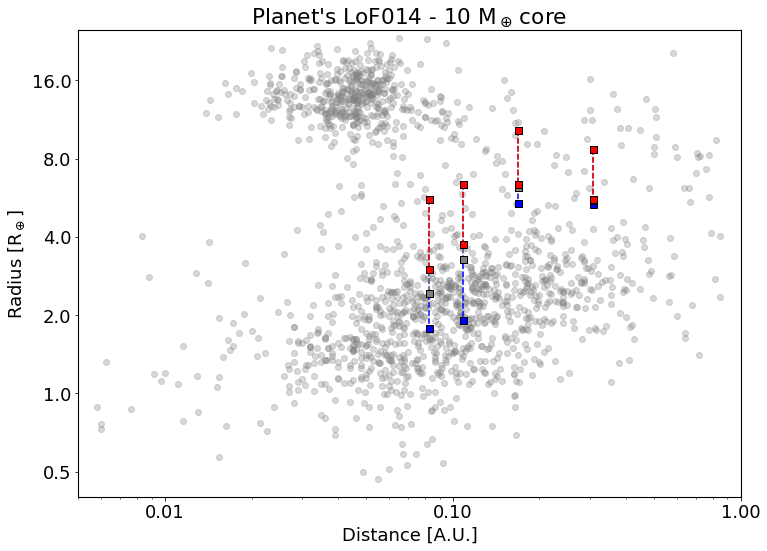

In [90]:
fig, ax = plt.subplots(figsize=(11, 8))

ax.set_title("Planet's LoF014 - 10 M$_\oplus\,$core")
ax.plot(ds, 2**log2R, marker="o", color="grey", alpha=0.3, ls="None")

ax.plot([pl_c_10.distance, pl_c_10.distance], [R1_c_10[0], R1_c_10[-1]], marker="s", ms=7, mec="k", color="blue", ls="--")
ax.plot([pl_c_10.distance, pl_c_10.distance], [R2_c_10[0], R2_c_10[-1]], marker="s", ms=7, mec="k", color="grey", ls="--")
ax.plot([pl_c_10.distance, pl_c_10.distance], [R3_c_10[0], R3_c_10[-1]], marker="s", ms=7, mec="k", color="red", ls="--")

ax.plot([pl_d_10.distance, pl_d_10.distance], [R1_d_10[0], R1_d_10[-1]], marker="s", ms=7, mec="k", color="blue", ls="--")
ax.plot([pl_d_10.distance, pl_d_10.distance], [R2_d_10[0], R2_d_10[-1]], marker="s", ms=7, mec="k", color="grey", ls="--")
ax.plot([pl_d_10.distance, pl_d_10.distance], [R3_d_10[0], R3_d_10[-1]], marker="s", ms=7, mec="k", color="red", ls="--")

ax.plot([pl_b_10.distance, pl_b_10.distance], [R1_b_10[0], R1_b_10[-1]], marker="s", ms=7, mec="k", color="blue", ls="--")
ax.plot([pl_b_10.distance, pl_b_10.distance], [R2_b_10[0], R2_b_10[-1]], marker="s", ms=7, mec="k", color="grey", ls="--")
ax.plot([pl_b_10.distance, pl_b_10.distance], [R3_b_10[0], R3_b_10[-1]], marker="s", ms=7, mec="k", color="red", ls="--")

ax.plot([pl_e_10.distance, pl_e_10.distance], [R1_e_10[0], R1_e_10[-1]], marker="s", ms=7, mec="k", color="blue", ls="--")
ax.plot([pl_e_10.distance, pl_e_10.distance], [R2_e_10[0], R2_e_10[-1]], marker="s", ms=7, mec="k", color="grey", ls="--")
ax.plot([pl_e_10.distance, pl_e_10.distance], [R3_e_10[0], R3_e_10[-1]], marker="s", ms=7, mec="k", color="red", ls="--")

ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.2f}'))
ax.set_ylabel("Radius [R$_\oplus$]")
ax.set_xlabel("Distance [A.U.]")
ax.loglog(basey=2, basex=10)
ax.set_ylim(0.4, 25)
ax.set_xlim(0.005, 1.0)

import matplotlib.ticker
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

plt.tight_layout()
plt.show()

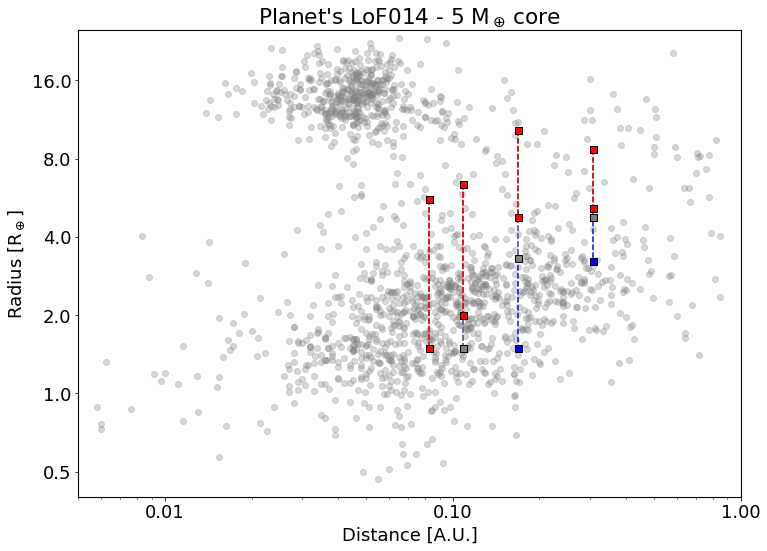

In [91]:
fig, ax = plt.subplots(figsize=(11, 8))

ax.set_title("Planet's LoF014 - 5 M$_\oplus\,$core")
ax.plot(ds, 2**log2R, marker="o", color="grey", alpha=0.3, ls="None")

ax.plot([pl_c_5.distance, pl_c_5.distance], [R1_c_5[0], R1_c_5[-1]], marker="s", ms=7, mec="k", color="blue", ls="--")
ax.plot([pl_c_5.distance, pl_c_5.distance], [R2_c_5[0], R2_c_5[-1]], marker="s", ms=7, mec="k", color="grey", ls="--")
ax.plot([pl_c_5.distance, pl_c_5.distance], [R3_c_5[0], R3_c_5[-1]], marker="s", ms=7, mec="k", color="red", ls="--")

ax.plot([pl_d_5.distance, pl_d_5.distance], [R1_d_5[0], R1_d_5[-1]], marker="s", ms=7, mec="k", color="blue", ls="--")
ax.plot([pl_d_5.distance, pl_d_5.distance], [R2_d_5[0], R2_d_5[-1]], marker="s", ms=7, mec="k", color="grey", ls="--")
ax.plot([pl_d_5.distance, pl_d_5.distance], [R3_d_5[0], R3_d_5[-1]], marker="s", ms=7, mec="k", color="red", ls="--")

ax.plot([pl_b_5.distance, pl_b_5.distance], [R1_b_5[0], R1_b_5[-1]], marker="s", ms=7, mec="k", color="blue", ls="--")
ax.plot([pl_b_5.distance, pl_b_5.distance], [R2_b_5[0], R2_b_5[-1]], marker="s", ms=7, mec="k", color="grey", ls="--")
ax.plot([pl_b_5.distance, pl_b_5.distance], [R3_b_5[0], R3_b_5[-1]], marker="s", ms=7, mec="k", color="red", ls="--")

ax.plot([pl_e_5.distance, pl_e_5.distance], [R1_e_5[0], R1_e_5[-1]], marker="s", ms=7, mec="k", color="blue", ls="--")
ax.plot([pl_e_5.distance, pl_e_5.distance], [R2_e_5[0], R2_e_5[-1]], marker="s", ms=7, mec="k", color="grey", ls="--")
ax.plot([pl_e_5.distance, pl_e_5.distance], [R3_e_5[0], R3_e_5[-1]], marker="s", ms=7, mec="k", color="red", ls="--")

ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.2f}'))
ax.set_ylabel("Radius [R$_\oplus$]")
ax.set_xlabel("Distance [A.U.]")
ax.loglog(basey=2, basex=10)
ax.set_ylim(0.4, 25)
ax.set_xlim(0.005, 1.0)

import matplotlib.ticker
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

plt.tight_layout()
plt.show()

# Addditional stuff

In [ ]:
t1, M1, R1, Lx1 = pl_c_10.read_results("./")

In [ ]:
t, M, R # my old code goes one time step further, i.e. to 192.9 -> CHECK WHY!
# -> old results: t_end = 192.90341377162815, M_end - 5.972364730419773e+28 = 10 M_earth, R_end = 1134204390.5169253 = 1.778 = R_core

In [14]:
R1[-1], R2[-1], R3[-1]

(1.7782794100389228, 2.441383425585101, 3.0223415552531763)

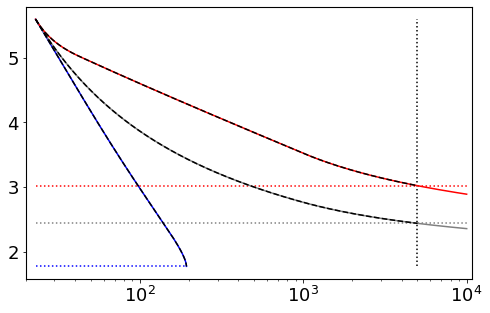

In [24]:
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(t1_c_10_2, R1_c_10_2, c="blue")
ax.plot(t2_c_10_2, R2_c_10_2, c="grey")
ax.plot(t3_c_10_2, R3_c_10_2, c="red")

ax.plot(t1_c_10, R1_c_10, c="k", ls="--")
ax.plot(t2_c_10, R2_c_10, c="k", ls="--")
ax.plot(t3_c_10, R3_c_10, c="k", ls="--")

ax.vlines(5000, np.min(R1_c_10), np.max(R1_c_10), ls=":", color="k")
ax.hlines(np.min(R1_c_10), np.min(t1_c_10_2), np.max(t1_c_10_2), ls=":", color="blue")
ax.hlines(np.min(R2_c_10), np.min(t2_c_10_2), np.max(t2_c_10_2), ls=":", color="grey")
ax.hlines(np.min(R3_c_10), np.min(t3_c_10_2), np.max(t3_c_10_2), ls=":", color="red")

ax.set_xticks([20,100,300,1000])
ax.set_xlim(20,10800)
ax.set_xscale("log")
plt.show()

In [39]:
R1_d_10[-1], R2_d_10[-1], R3_d_10[-1]

(1.907746135292936, 3.285915447567908, 3.772635444773706)

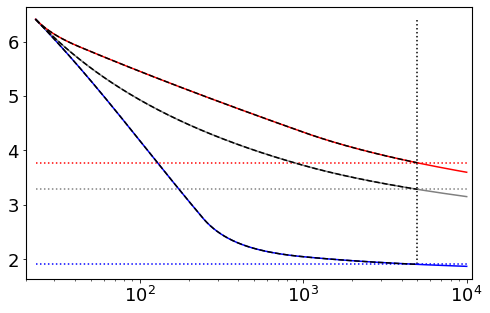

In [19]:
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(t1_d_10_2, R1_d_10_2, c="blue")
ax.plot(t2_d_10_2, R2_d_10_2, c="grey")
ax.plot(t3_d_10_2, R3_d_10_2, c="red")

ax.plot(t1_d_10, R1_d_10, c="k", ls="--")
ax.plot(t2_d_10, R2_d_10, c="k", ls="--")
ax.plot(t3_d_10, R3_d_10, c="k", ls="--")

ax.vlines(5000, np.min(R1_d_10), np.max(R1_d_10), ls=":", color="k")
ax.hlines(np.min(R1_d_10), np.min(t1_d_10_2), np.max(t1_d_10_2), ls=":", color="blue")
ax.hlines(np.min(R2_d_10), np.min(t2_d_10_2), np.max(t2_d_10_2), ls=":", color="grey")
ax.hlines(np.min(R3_d_10), np.min(t3_d_10_2), np.max(t3_d_10_2), ls=":", color="red")

ax.set_xticks([20,100,300,1000])
ax.set_xlim(20,10800)
ax.set_xscale("log")
plt.show()

# Plot planet population

In [26]:
# Instantiate exoplanetEU2 object (download all the planets)
v = pyasl.ExoplanetEU2()
# Export all data as a pandas DataFrame
planets = v.getAllDataPandas()
planets_masses = planets[~np.isnan(planets["mass"])]

mask_nan = ~(np.isnan(planets["orbital_period"]) | np.isnan(planets["radius"]))
mask_P = planets["orbital_period"]<300
planets_ = planets[mask_nan & mask_P] # dataframe only with planets which have P & R

R_to_earth = 11.2
period = planets_["orbital_period"].values
radius = planets_["radius"].values*R_to_earth
ds = planets_["semi_major_axis"].values

# actual data -> transform to log space
log3P = np.log(period)/np.log(3)
log2R = np.log(radius)/np.log(2)

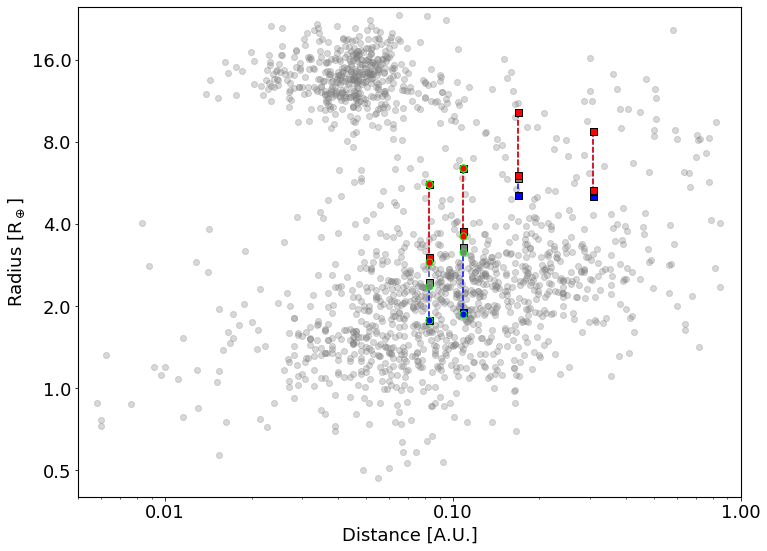

In [48]:
fig, ax = plt.subplots(figsize=(11, 8))
ax.plot(ds, 2**log2R, marker="o", color="grey", alpha=0.3, ls="None")

#ax.plot(planet_case1.distance, planet_case1.radius, marker="s", mec="k", color="aquamarine")
#ax.plot(planet_case1.distance, R1[-1], marker="s", mec="k", color="blue")
#ax.plot(planet_case1.distance, R2[-1], marker="s", mec="k", color="green")
#ax.plot(planet_case1.distance, R3[-1], marker="s", mec="k", color="darkred")

ax.plot([pl_c_10.distance, pl_c_10.distance], [R1_c_10[0], R1_c_10[-1]], marker="s", ms=7, mec="k", color="blue", ls="--")
ax.plot([pl_c_10.distance, pl_c_10.distance], [R2_c_10[0], R2_c_10[-1]], marker="s", ms=7, mec="k", color="grey", ls="--")
ax.plot([pl_c_10.distance, pl_c_10.distance], [R3_c_10[0], R3_c_10[-1]], marker="s", ms=7, mec="k", color="red", ls="--")

ax.plot([pl_c_10.distance, pl_c_10.distance], [R1_c_10_2[0], R1_c_10_2[-1]], marker="o", ms=7, mec="lime", color="blue", ls="None")
ax.plot([pl_c_10.distance, pl_c_10.distance], [R2_c_10_2[0], R2_c_10_2[-1]], marker="o", ms=7, mec="lime", color="grey", ls="None")
ax.plot([pl_c_10.distance, pl_c_10.distance], [R3_c_10_2[0], R3_c_10_2[-1]], marker="o", ms=7, mec="lime", color="red", ls="None")

ax.plot([pl_d_10.distance, pl_d_10.distance], [R1_d_10[0], R1_d_10[-1]], marker="s", ms=7, mec="k", color="blue", ls="--")
ax.plot([pl_d_10.distance, pl_d_10.distance], [R2_d_10[0], R2_d_10[-1]], marker="s", ms=7, mec="k", color="grey", ls="--")
ax.plot([pl_d_10.distance, pl_d_10.distance], [R3_d_10[0], R3_d_10[-1]], marker="s", ms=7, mec="k", color="red", ls="--")

ax.plot([pl_d_10.distance, pl_d_10.distance], [R1_d_10_2[0], R1_d_10_2[-1]], marker="o", ms=7, mec="lime", color="blue", ls="None")
ax.plot([pl_d_10.distance, pl_d_10.distance], [R2_d_10_2[0], R2_d_10_2[-1]], marker="o", ms=7, mec="lime", color="grey", ls="None")
ax.plot([pl_d_10.distance, pl_d_10.distance], [R3_d_10_2[0], R3_d_10_2[-1]], marker="o", ms=7, mec="lime", color="red", ls="None")

ax.plot([pl_b_10.distance, pl_b_10.distance], [R1_b_10[0], R1_b_10[-1]], marker="s", ms=7, mec="k", color="blue", ls="--")
ax.plot([pl_b_10.distance, pl_b_10.distance], [R2_b_10[0], R2_b_10[-1]], marker="s", ms=7, mec="k", color="grey", ls="--")
ax.plot([pl_b_10.distance, pl_b_10.distance], [R3_b_10[0], R3_b_10[-1]], marker="s", ms=7, mec="k", color="red", ls="--")

ax.plot([pl_e_10.distance, pl_e_10.distance], [R1_e_10[0], R1_e_10[-1]], marker="s", ms=7, mec="k", color="blue", ls="--")
ax.plot([pl_e_10.distance, pl_e_10.distance], [R2_e_10[0], R2_e_10[-1]], marker="s", ms=7, mec="k", color="grey", ls="--")
ax.plot([pl_e_10.distance, pl_e_10.distance], [R3_e_10[0], R3_e_10[-1]], marker="s", ms=7, mec="k", color="red", ls="--")

ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.2f}'))
ax.set_ylabel("Radius [R$_\oplus$]")
ax.set_xlabel("Distance [A.U.]")
ax.loglog(basey=2, basex=10)
ax.set_ylim(0.4, 25)
ax.set_xlim(0.005, 1.0)

import matplotlib.ticker
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

plt.tight_layout()
plt.show()

# ADD PLOT FROM PAPER

# Influence of errors on $L_x$ - evolve planets with lower & upper Lx

## LoFo14 - Mcore10

In [ ]:
%%time

star_V1298Tau = {'star_id': 'V1298Tau', 'mass': mass_star, 'radius': radius_star, 'age': age_star, 'L_bol': L_bol, 'Lx_age': Lx_age-Lx_age_error}
pl_c_10 = planet_LoFo14(star_dictionary=star_V1298Tau, planet_dict=planet_c_10)
pl_d_10 = planet_LoFo14(star_dictionary=star_V1298Tau, planet_dict=planet_d_10)
pl_b_10 = planet_LoFo14(star_dictionary=star_V1298Tau, planet_dict=planet_b_10)
pl_e_10 = planet_LoFo14(star_dictionary=star_V1298Tau, planet_dict=planet_e_10)

try:
    p = os.getcwd()+"/LoFo14_Results_varstep_upperLx/10_Mcore/"
    os.mkdir(p)
    curr_path = p
    print(curr_path)
except:
    try:
        os.mkdir(os.getcwd()+"/LoFo14_Results_varstep_upperLx/")
        os.mkdir(os.getcwd()+"/LoFo14_Results_varstep_upperLx/10_Mcore/")
        curr_path = os.getcwd()+"/LoFo14_Results_varstep_upperLx/10_Mcore/"
        print(curr_path)
    except:  
        print("Path exists")
        curr_path = os.getcwd()+"/LoFo14_Results_varstep_upperLx/10_Mcore/"
        print(curr_path)
    
folders = ["planet_c", "planet_d", "planet_b", "planet_e"]
for f in folders:
    if os.path.isdir(curr_path+f) == True:
        pass
    else:
        os.mkdir(curr_path+f)

# planet c
folder = folders[0]
pl_c_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_c_10u, M1_c_10u, R1_c_10u, Lx1_c_10u = pl_c_10.read_results(curr_path+folder+"/")
pl_c_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_c_10u, M2_c_10u, R2_c_10u, Lx2_c_10u = pl_c_10.read_results(curr_path+folder+"/")
pl_c_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_c_10u, M3_c_10u, R3_c_10u, Lx3_c_10u = pl_c_10.read_results(curr_path+folder+"/")

# planet d
folder = folders[1]
pl_d_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_d_10u, M1_d_10u, R1_d_10u, Lx1_d_10u = pl_d_10.read_results(curr_path+folder+"/")
pl_d_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_d_10u, M2_d_10u, R2_d_10u, Lx2_d_10u = pl_d_10.read_results(curr_path+folder+"/")
pl_d_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_d_10u, M3_d_10u, R3_d_10u, Lx3_d_10u = pl_d_10.read_results(curr_path+folder+"/")

# planet b
folder = folders[2]
pl_b_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_b_10u, M1_b_10u, R1_b_10u, Lx1_b_10u_2 = pl_b_10.read_results(curr_path+folder+"/")
pl_b_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_b_10u, M2_b_10u, R2_b_10u, Lx2_b_10u_2 = pl_b_10.read_results(curr_path+folder+"/")
pl_b_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_b_10u, M3_b_10u, R3_b_10u, Lx3_b_10u_2 = pl_b_10.read_results(curr_path+folder+"/")

# planet e
folder = folders[3]
pl_e_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_e_10u, M1_e_10u, R1_e_10u, Lx1_e_10u_2 = pl_e_10.read_results(curr_path+folder+"/")
pl_e_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_e_10u, M2_e_10u, R2_e_10u, Lx2_e_10u_2 = pl_e_10.read_results(curr_path+folder+"/")
pl_e_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_e_10u, M3_e_10u, R3_e_10u, Lx3_e_10u_2 = pl_e_10.read_results(curr_path+folder+"/")


try:
    p = os.getcwd()+"/LoFo14_Results_varstep_lowerLx/10_Mcore/"
    os.mkdir(p)
    curr_path = p
    print(curr_path)
except:
    try:
        os.mkdir(os.getcwd()+"/LoFo14_Results_varstep_lowerLx/")
        os.mkdir(os.getcwd()+"/LoFo14_Results_varstep_lowerLx/10_Mcore/")
        curr_path = os.getcwd()+"/LoFo14_Results_varstep_lowerLx/10_Mcore/"
        print(curr_path)
    except:  
        print("Path exists")
        curr_path = os.getcwd()+"/LoFo14_Results_varstep_lowerLx/10_Mcore/"
        print(curr_path)
    
folders = ["planet_c", "planet_d", "planet_b", "planet_e"]
for f in folders:
    if os.path.isdir(curr_path+f) == True:
        pass
    else:
        os.mkdir(curr_path+f)

# planet c
folder = folders[0]
pl_c_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_c_10l, M1_c_10l, R1_c_10l, Lx1_c_10l = pl_c_10.read_results(curr_path+folder+"/")
pl_c_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_c_10l, M2_c_10l, R2_c_10l, Lx2_c_10l = pl_c_10.read_results(curr_path+folder+"/")
pl_c_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_c_10l, M3_c_10l, R3_c_10l, Lx3_c_10l = pl_c_10.read_results(curr_path+folder+"/")

# planet d
folder = folders[1]
pl_d_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_d_10l, M1_d_10l, R1_d_10l, Lx1_d_10l = pl_d_10.read_results(curr_path+folder+"/")
pl_d_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_d_10l, M2_d_10l, R2_d_10l, Lx2_d_10l = pl_d_10.read_results(curr_path+folder+"/")
pl_d_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_d_10l, M3_d_10l, R3_d_10l, Lx3_d_10l = pl_d_10.read_results(curr_path+folder+"/")

# planet b
folder = folders[2]
pl_b_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_b_10l, M1_b_10l, R1_b_10l, Lx1_b_10l = pl_b_10.read_results(curr_path+folder+"/")
pl_b_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_b_10l, M2_b_10l, R2_b_10l, Lx2_b_10l = pl_b_10.read_results(curr_path+folder+"/")
pl_b_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_b_10l, M3_b_10l, R3_b_10l, Lx3_b_10l = pl_b_10.read_results(curr_path+folder+"/")

# planet e
folder = folders[3]
pl_e_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_e_10l, M1_e_10l, R1_e_10l, Lx1_e_10l = pl_e_10.read_results(curr_path+folder+"/")
pl_e_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_e_10l, M2_e_10l, R2_e_10l, Lx2_e_10l = pl_e_10.read_results(curr_path+folder+"/")
pl_e_10.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_e_10l, M3_e_10l, R3_e_10l, Lx3_e_10l = pl_e_10.read_results(curr_path+folder+"/")

## LoFo14 - Mcore5

In [ ]:
%%time

star_V1298Tau = {'star_id': 'V1298Tau', 'mass': mass_star, 'radius': radius_star, 'age': age_star, 'L_bol': L_bol, 'Lx_age': Lx_age+Lx_age_error}
# variable step size
pl_c_5 = planet_LoFo14(star_dictionary=star_V1298Tau, planet_dict=planet_c_5)
pl_d_5 = planet_LoFo14(star_dictionary=star_V1298Tau, planet_dict=planet_d_5)
pl_b_5 = planet_LoFo14(star_dictionary=star_V1298Tau, planet_dict=planet_b_5)
pl_e_5 = planet_LoFo14(star_dictionary=star_V1298Tau, planet_dict=planet_e_5)

try:
    p = os.getcwd()+"/LoFo14_Results_new_upperLx/5_Mcore/"
    os.mkdir(p)
    curr_path = p
    print(curr_path)
except:
    try:
        os.mkdir(os.getcwd()+"/LoFo14_Results_new_upperLx/")
        os.mkdir(os.getcwd()+"/LoFo14_Results_new_upperLx/5_Mcore/")
        curr_path = os.getcwd()+"/LoFo14_Results_new_upperLx/5_Mcore/"
        print(curr_path)
    except:  
        print("Path exists")
        curr_path = os.getcwd()+"/LoFo14_Results_new_upperLx/5_Mcore/"
        print(curr_path)
    
folders = ["planet_c", "planet_d", "planet_b", "planet_e"]
for f in folders:
    if os.path.isdir(curr_path+f) == True:
        pass
    else:
        os.mkdir(curr_path+f)

# planet c
folder = folders[0]
pl_c_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_c_5u, M1_c_5u, R1_c_5u, Lx1_c_5u = pl_c_5.read_results(curr_path+folder+"/")
pl_c_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_c_5u, M2_c_5u, R2_c_5u, Lx2_c_5u = pl_c_5.read_results(curr_path+folder+"/")
pl_c_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_c_5u, M3_c_5u, R3_c_5u, Lx3_c_5u = pl_c_5.read_results(curr_path+folder+"/")

# planet d
folder = folders[1]
pl_d_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_d_5u, M1_d_5u, R1_d_5u, Lx1_d_5u = pl_d_5.read_results(curr_path+folder+"/")
pl_d_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_d_5u, M2_d_5u, R2_d_5u, Lx2_d_5u = pl_d_5.read_results(curr_path+folder+"/")
pl_d_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_d_5u, M3_d_5u, R3_d_5u, Lx3_d_5u = pl_d_5.read_results(curr_path+folder+"/")

# planet b
folder = folders[2]
pl_b_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_b_5u, M1_b_5u, R1_b_5u, Lx1_b_5u_2 = pl_b_5.read_results(curr_path+folder+"/")
pl_b_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_b_5u, M2_b_5u, R2_b_5u, Lx2_b_5u_2 = pl_b_5.read_results(curr_path+folder+"/")
pl_b_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_b_5u, M3_b_5u, R3_b_5u, Lx3_b_5u_2 = pl_b_5.read_results(curr_path+folder+"/")

# planet e
folder = folders[3]
pl_e_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_e_5u, M1_e_5u, R1_e_5u, Lx1_e_5u_2 = pl_e_5.read_results(curr_path+folder+"/")
pl_e_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_e_5u, M2_e_5u, R2_e_5u, Lx2_e_5u_2 = pl_e_5.read_results(curr_path+folder+"/")
pl_e_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_e_5u, M3_e_5u, R3_e_5u, Lx3_e_5u_2 = pl_e_5.read_results(curr_path+folder+"/")


try:
    p = os.getcwd()+"/LoFo14_Results_varstep_lowerLx/5_Mcore/"
    os.mkdir(p)
    curr_path = p
    print(curr_path)
except:
    try:
        os.mkdir(os.getcwd()+"/LoFo14_Results_varstep_lowerLx/")
        os.mkdir(os.getcwd()+"/LoFo14_Results_varstep_lowerLx/5_Mcore/")
        curr_path = os.getcwd()+"/LoFo14_Results_varstep_lowerLx/5_Mcore/"
        print(curr_path)
    except:  
        print("Path exists")
        curr_path = os.getcwd()+"/LoFo14_Results_varstep_lowerLx/5_Mcore/"
        print(curr_path)
    
folders = ["planet_c", "planet_d", "planet_b", "planet_e"]
for f in folders:
    if os.path.isdir(curr_path+f) == True:
        pass
    else:
        os.mkdir(curr_path+f)

# planet c
folder = folders[0]
pl_c_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_c_5l, M1_c_5l, R1_c_5l, Lx1_c_5l = pl_c_5.read_results(curr_path+folder+"/")
pl_c_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_c_5l, M2_c_5l, R2_c_5l, Lx2_c_5l = pl_c_5.read_results(curr_path+folder+"/")
pl_c_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_c_5l, M3_c_5l, R3_c_5l, Lx3_c_5l = pl_c_5.read_results(curr_path+folder+"/")

# planet d
folder = folders[1]
pl_d_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_d_5l, M1_d_5l, R1_d_5l, Lx1_d_5l = pl_d_5.read_results(curr_path+folder+"/")
pl_d_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_d_5l, M2_d_5l, R2_d_5l, Lx2_d_5l = pl_d_5.read_results(curr_path+folder+"/")
pl_d_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_d_5l, M3_d_5l, R3_d_5l, Lx3_d_5l = pl_d_5.read_results(curr_path+folder+"/")

# planet b
folder = folders[2]
pl_b_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_b_5l, M1_b_5l, R1_b_5l, Lx1_b_5l_2 = pl_b_5.read_results(curr_path+folder+"/")
pl_b_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_b_5l, M2_b_5l, R2_b_5l, Lx2_b_5l_2 = pl_b_5.read_results(curr_path+folder+"/")
pl_b_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_b_5l, M3_b_5l, R3_b_5l, Lx3_b_5l_2 = pl_b_5.read_results(curr_path+folder+"/")

# planet e
folder = folders[3]
pl_e_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_e_5l, M1_e_5l, R1_e_5l, Lx1_e_5l_2 = pl_e_5.read_results(curr_path+folder+"/")
pl_e_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_e_5l, M2_e_5l, R2_e_5l, Lx2_e_5l_2 = pl_e_5.read_results(curr_path+folder+"/")
pl_e_5.evolve_forward(5000., 0.1, 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_e_5l, M3_e_5l, R3_e_5l, Lx3_e_5l_2 = pl_e_5.read_results(curr_path+folder+"/")

## Ot20 

In [ ]:
%%time

star_V1298Tau = {'star_id': 'V1298Tau', 'mass': mass_star, 'radius': radius_star, 'age': age_star, 'L_bol': L_bol, 'Lx_age': Lx_age-Lx_age_error}
# variable step size
pl_c_Ot = planet_Ot20(star_dictionary=star_V1298Tau, planet_dict=planet_c_Ot)
pl_d_Ot = planet_Ot20(star_dictionary=star_V1298Tau, planet_dict=planet_d_Ot)
pl_b_Ot = planet_Ot20(star_dictionary=star_V1298Tau, planet_dict=planet_b_Ot)
pl_e_Ot = planet_Ot20(star_dictionary=star_V1298Tau, planet_dict=planet_e_Ot)

try:
    p = os.getcwd()+"/Otegi_results_upperLx/"
    os.mkdir(p)
    curr_path = p
    print(curr_path)
except:
    print("Path exists")
    curr_path = os.getcwd()+"/Otegi_results_upperLx/"
    print(curr_path)

folders = ["planet_c", "planet_d", "planet_b", "planet_e"]
for f in folders:
    if os.path.isdir(curr_path+f) == True:
        pass
    else:
        os.mkdir(curr_path+f)

# planet c
folder = folders[0]
pl_c_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_c_Otu, M1_c_Otu, R1_c_Otu, Lx1_c_Otu = pl_c_Ot.read_results(curr_path+folder+"/")
pl_c_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_c_Otu, M2_c_Otu, R2_c_Otu, Lx2_c_Otu = pl_c_Ot.read_results(curr_path+folder+"/")
pl_c_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_c_Otu, M3_c_Otu, R3_c_Otu, Lx3_c_Otu = pl_c_Ot.read_results(curr_path+folder+"/")

# planet d
folder = folders[1]
pl_d_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_d_Otu, M1_d_Otu, R1_d_Otu, Lx1_d_Otu = pl_d_Ot.read_results(curr_path+folder+"/")
pl_d_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_d_Otu, M2_d_Otu, R2_d_Otu, Lx2_d_Otu = pl_d_Ot.read_results(curr_path+folder+"/")
pl_d_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_d_Otu, M3_d_Otu, R3_d_Otu, Lx3_d_Otu = pl_d_Ot.read_results(curr_path+folder+"/")

# planet b
folder = folders[2]
pl_b_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_b_Otu, M1_b_Otu, R1_b_Otu, Lx1_b_Otu = pl_b_Ot.read_results(curr_path+folder+"/")
pl_b_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_b_Otu, M2_b_Otu, R2_b_Otu, Lx2_b_Otu = pl_b_Ot.read_results(curr_path+folder+"/")
pl_b_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_b_Otu, M3_b_Otu, R3_b_Otu, Lx3_b_Otu = pl_b_Ot.read_results(curr_path+folder+"/")

# planet e
folder = folders[3]
pl_e_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_e_Otu, M1_e_Otu, R1_e_Otu, Lx1_e_Otu = pl_e_Ot.read_results(curr_path+folder+"/")
pl_e_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_e_Otu, M2_e_Otu, R2_e_Otu, Lx2_e_Otu = pl_e_Ot.read_results(curr_path+folder+"/")
pl_e_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3_upper, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_e_Otu, M3_e_Otu, R3_e_Otu, Lx3_e_Otu = pl_e_Ot.read_results(curr_path+folder+"/")


try:
    p = os.getcwd()+"/Otegi_results_lowerLx/"
    os.mkdir(p)
    curr_path = p
    print(curr_path)
except:
    print("Path exists")
    curr_path = os.getcwd()+"/Otegi_results_lowerLx/"
    print(curr_path)

folders = ["planet_c", "planet_d", "planet_b", "planet_e"]
for f in folders:
    if os.path.isdir(curr_path+f) == True:
        pass
    else:
        os.mkdir(curr_path+f)

# planet c
folder = folders[0]
pl_c_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_c_Otl, M1_c_Otl, R1_c_Otl, Lx1_c_Otl = pl_c_Ot.read_results(curr_path+folder+"/")
pl_c_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_c_Otl, M2_c_Otl, R2_c_Otl, Lx2_c_Otl = pl_c_Ot.read_results(curr_path+folder+"/")
pl_c_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_c_Otl, M3_c_Otl, R3_c_Otl, Lx3_c_Otl = pl_c_Ot.read_results(curr_path+folder+"/")

# planet d
folder = folders[1]
pl_d_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_d_Otl, M1_d_Otl, R1_d_Otl, Lx1_d_Otl = pl_d_Ot.read_results(curr_path+folder+"/")
pl_d_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_d_Otl, M2_d_Otl, R2_d_Otl, Lx2_d_Otl = pl_d_Ot.read_results(curr_path+folder+"/")
pl_d_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_d_Otl, M3_d_Otl, R3_d_Otl, Lx3_d_Otl = pl_d_Ot.read_results(curr_path+folder+"/")

# planet b
folder = folders[2]
pl_b_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_b_Otl, M1_b_Otl, R1_b_Otl, Lx1_b_Otl = pl_b_Ot.read_results(curr_path+folder+"/")
pl_b_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_b_Otl, M2_b_Otl, R2_b_Otl, Lx2_b_Otl = pl_b_Ot.read_results(curr_path+folder+"/")
pl_b_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_b_Otl, M3_b_Otl, R3_b_Otl, Lx3_b_Otl = pl_b_Ot.read_results(curr_path+folder+"/")

# planet e
folder = folders[3]
pl_e_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track1_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t1_e_Otl, M1_e_Otl, R1_e_Otl, Lx1_e_Otl = pl_e_Ot.read_results(curr_path+folder+"/")
pl_e_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track2_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t2_e_Otl, M2_e_Otl, R2_e_Otl, Lx2_e_Otl = pl_e_Ot.read_results(curr_path+folder+"/")
pl_e_Ot.evolve_forward(5000., 1., 0.1, K_on="yes", beta_on="yes", evo_track_dict=track3_lower, path_for_saving=curr_path+folder+"/", planet_folder_id=folder)
t3_e_Otl, M3_e_Otl, R3_e_Otl, Lx3_e_Otl = pl_e_Ot.read_results(curr_path+folder+"/")

# Differences between upper and lower Lx_age

## Planet c

In [ ]:
Lx_up = Lx_age+Lx_age_error
Lx = Lx_age
Lx_lo = Lx_age-Lx_age_error

def calc_fenv(M_tot, M_core):
    return ((M_tot-M_core)/M_tot)*100


dfc = pd.DataFrame(columns=["Lx_init", "t_final_high", "t_final_med", "t_final_low", 
                            "M_init", "fenv", "M_final_high", "fenv_high", "M_final_med", "fenv_med", "M_final_low", "fenv_low", 
                            "R_init", "R_final_high", "R_final_med", "R_final_low"])
dfc.loc[0] = [Lx_up, t1_c_5u[-1], t2_c_5u[-1], t3_c_5u[-1], 
              M1_c_5u[0], calc_fenv(M1_c_5u[0], 5.0), M1_c_5u[-1], calc_fenv(M1_c_5u[-1], 5.0), 
              M2_c_5u[-1], calc_fenv(M2_c_5u[-1], 5.0), M3_c_5u[-1], calc_fenv(M3_c_5u[-1], 5.0), 
              R1_c_5u[0], R1_c_5u[-1], R2_c_5u[-1], R3_c_5u[-1]]
dfc.loc[1] = [Lx, t1_c_5[-1], t2_c_5[-1], t3_c_5[-1], 
              M1_c_5[0], calc_fenv(M1_c_5[0], 5.0), M1_c_5[-1], calc_fenv(M1_c_5[-1], 5.0), 
              M2_c_5[-1], calc_fenv(M2_c_5[-1], 5.0), M3_c_5[-1], calc_fenv(M3_c_5[-1], 5.0), 
              R1_c_5[0], R1_c_5[-1], R2_c_5[-1], R3_c_5[-1]]
dfc.loc[2] = [Lx_lo, t1_c_5l[-1], t2_c_5l[-1], t3_c_5l[-1], 
              M1_c_5l[0], calc_fenv(M1_c_5l[0], 5.0), M1_c_5l[-1], calc_fenv(M1_c_5l[-1], 5.0), 
              M2_c_5l[-1], calc_fenv(M2_c_5l[-1], 5.0), M3_c_5l[-1], calc_fenv(M3_c_5l[-1], 5.0), 
              R1_c_5l[0], R1_c_5l[-1], R2_c_5l[-1], R3_c_5l[-1]]

dfc.loc[3] = [Lx_up, t1_c_10u[-1], t2_c_10u[-1], t3_c_10u[-1], 
              M1_c_10u[0], calc_fenv(M1_c_10u[0], 10.0), M1_c_10u[-1], calc_fenv(M1_c_10u[-1], 10.0), 
              M2_c_10u[-1], calc_fenv(M2_c_10u[-1], 10.0), M3_c_10u[-1], calc_fenv(M3_c_10u[-1], 10.0), 
              R1_c_10u[0], R1_c_10u[-1], R2_c_10u[-1], R3_c_10u[-1]]
dfc.loc[4] = [Lx, t1_c_10[-1], t2_c_10[-1], t3_c_10[-1], 
              M1_c_10[0], calc_fenv(M1_c_10[0], 10.0), M1_c_10[-1], calc_fenv(M1_c_10[-1], 10.0), 
              M2_c_10[-1], calc_fenv(M2_c_10[-1], 10.0), M3_c_10[-1], calc_fenv(M3_c_10[-1], 10.0), 
              R1_c_10[0], R1_c_10[-1], R2_c_10[-1], R3_c_10[-1]]
dfc.loc[5] = [Lx_lo, t1_c_10l[-1], t2_c_10l[-1], t3_c_10l[-1], 
              M1_c_10l[0], calc_fenv(M1_c_10l[0], 10.0), M1_c_10l[-1], calc_fenv(M1_c_10l[-1], 10.0), 
              M2_c_10l[-1], calc_fenv(M2_c_10l[-1], 10.0), M3_c_10l[-1], calc_fenv(M3_c_10l[-1], 10.0), 
              R1_c_10l[0], R1_c_10l[-1], R2_c_10l[-1], R3_c_10l[-1]]

dfc.loc[6] = [Lx_up, t1_c_Otu[-1], t2_c_Otu[-1], t3_c_Otu[-1], 
              M1_c_Otu[0], np.nan, M1_c_Otu[-1], np.nan, M2_c_Otu[-1], np.nan, M3_c_Otu[-1], np.nan, 
              R1_c_Otu[0], R1_c_Otu[-1], R2_c_Otu[-1], R3_c_Otu[-1]]
dfc.loc[7] = [Lx, t1_c_Ot[-1], t2_c_Ot[-1], t3_c_Ot[-1], 
              M1_c_Ot[0], np.nan, M1_c_Ot[-1], np.nan, M2_c_Ot[-1], np.nan, M3_c_Ot[-1], np.nan, 
              R1_c_Ot[0], R1_c_Ot[-1], R2_c_Ot[-1], R3_c_Ot[-1]]
dfc.loc[8] = [Lx_lo, t1_c_Otl[-1], t2_c_Otl[-1], t3_c_Otl[-1], 
              M1_c_Otl[0], np.nan, M1_c_Otl[-1], np.nan, M2_c_Otl[-1], np.nan, M3_c_Otl[-1], np.nan, 
              R1_c_Otl[0], R1_c_Otl[-1], R2_c_Otl[-1], R3_c_Otl[-1]]

dfc = dfc.round(3)
dfc

## Planet d

In [ ]:
dfd = pd.DataFrame(columns=["Lx_init", "t_final_high", "t_final_med", "t_final_low", 
                            "M_init", "fenv", "M_final_high", "fenv_high", "M_final_med", "fenv_med", "M_final_low", "fenv_low", 
                            "R_init", "R_final_high", "R_final_med", "R_final_low"])
dfd.loc[0] = [Lx_up, t1_d_5u[-1], t2_d_5u[-1], t3_d_5u[-1], 
              M1_d_5u[0], calc_fenv(M1_d_5u[0], 5.0), M1_d_5u[-1], calc_fenv(M1_d_5u[-1], 5.0), 
              M2_d_5u[-1], calc_fenv(M2_d_5u[-1], 5.0), M3_d_5u[-1], calc_fenv(M3_d_5u[-1], 5.0), 
              R1_d_5u[0], R1_d_5u[-1], R2_d_5u[-1], R3_d_5u[-1]]
dfd.loc[1] = [Lx, t1_d_5[-1], t2_d_5[-1], t3_d_5[-1], 
              M1_d_5[0], calc_fenv(M1_d_5[0], 5.0), M1_d_5[-1], calc_fenv(M1_d_5[-1], 5.0), 
              M2_d_5[-1], calc_fenv(M2_d_5[-1], 5.0), M3_d_5[-1], calc_fenv(M3_d_5[-1], 5.0), 
              R1_d_5[0], R1_d_5[-1], R2_d_5[-1], R3_d_5[-1]]
dfd.loc[2] = [Lx_lo, t1_d_5l[-1], t2_d_5l[-1], t3_d_5l[-1], 
              M1_d_5l[0], calc_fenv(M1_d_5l[0], 5.0), M1_d_5l[-1], calc_fenv(M1_d_5l[-1], 5.0), 
              M2_d_5l[-1], calc_fenv(M2_d_5l[-1], 5.0), M3_d_5l[-1], calc_fenv(M3_d_5l[-1], 5.0), 
              R1_d_5l[0], R1_d_5l[-1], R2_d_5l[-1], R3_d_5l[-1]]

dfd.loc[3] = [Lx_up, t1_d_10u[-1], t2_d_10u[-1], t3_d_10u[-1], 
              M1_d_10u[0], calc_fenv(M1_d_10u[0], 10.0), M1_d_10u[-1], calc_fenv(M1_d_10u[-1], 10.0), 
              M2_d_10u[-1], calc_fenv(M2_d_10u[-1], 10.0), M3_d_10u[-1], calc_fenv(M3_d_10u[-1], 10.0), 
              R1_d_10u[0], R1_d_10u[-1], R2_d_10u[-1], R3_d_10u[-1]]
dfd.loc[4] = [Lx, t1_d_10[-1], t2_d_10[-1], t3_d_10[-1], 
              M1_d_10[0], calc_fenv(M1_d_10[0], 10.0), M1_d_10[-1], calc_fenv(M1_d_10[-1], 10.0), 
              M2_d_10[-1], calc_fenv(M2_d_10[-1], 10.0), M3_d_10[-1], calc_fenv(M3_d_10[-1], 10.0), 
              R1_d_10[0], R1_d_10[-1], R2_d_10[-1], R3_d_10[-1]]
dfd.loc[5] = [Lx_lo, t1_d_10l[-1], t2_d_10l[-1], t3_d_10l[-1], 
              M1_d_10l[0], calc_fenv(M1_d_10l[0], 10.0), M1_d_10l[-1], calc_fenv(M1_d_10l[-1], 10.0), 
              M2_d_10l[-1], calc_fenv(M2_d_10l[-1], 10.0), M3_d_10l[-1], calc_fenv(M3_d_10l[-1], 10.0), 
              R1_d_10l[0], R1_d_10l[-1], R2_d_10l[-1], R3_d_10l[-1]]

dfd.loc[6] = [Lx_up, t1_d_Otu[-1], t2_d_Otu[-1], t3_d_Otu[-1], 
              M1_d_Otu[0], np.nan, M1_d_Otu[-1], np.nan, M2_d_Otu[-1], np.nan, M3_d_Otu[-1], np.nan, 
              R1_d_Otu[0], R1_d_Otu[-1], R2_d_Otu[-1], R3_d_Otu[-1]]
dfd.loc[7] = [Lx, t1_d_Ot[-1], t2_d_Ot[-1], t3_d_Ot[-1], 
              M1_d_Ot[0], np.nan, M1_d_Ot[-1], np.nan, M2_d_Ot[-1], np.nan, M3_d_Ot[-1], np.nan, 
              R1_d_Ot[0], R1_d_Ot[-1], R2_d_Ot[-1], R3_d_Ot[-1]]
dfd.loc[8] = [Lx_lo, t1_d_Otl[-1], t2_d_Otl[-1], t3_d_Otl[-1], 
              M1_d_Otl[0], np.nan, M1_d_Otl[-1], np.nan, M2_d_Otl[-1], np.nan, M3_d_Otl[-1], np.nan, 
              R1_d_Otl[0], R1_d_Otl[-1], R2_d_Otl[-1], R3_d_Otl[-1]]

dfd = dfd.round(2)
dfd

## Planet b

In [ ]:
dfb = pd.DataFrame(columns=["Lx_init", "t_final_high", "t_final_med", "t_final_low", 
                            "M_init", "fenv", "M_final_high", "fenv_high", "M_final_med", "fenv_med", "M_final_low", "fenv_low", 
                            "R_init", "R_final_high", "R_final_med", "R_final_low"])
dfb.loc[0] = [Lx_up, t1_b_5u[-1], t2_b_5u[-1], t3_b_5u[-1], 
              M1_b_5u[0], calc_fenv(M1_b_5u[0], 5.0), M1_b_5u[-1], calc_fenv(M1_b_5u[-1], 5.0), 
              M2_b_5u[-1], calc_fenv(M2_b_5u[-1], 5.0), M3_b_5u[-1], calc_fenv(M3_b_5u[-1], 5.0), 
              R1_b_5u[0], R1_b_5u[-1], R2_b_5u[-1], R3_b_5u[-1]]
dfb.loc[1] = [Lx, t1_b_5[-1], t2_b_5[-1], t3_b_5[-1], 
              M1_b_5[0], calc_fenv(M1_b_5[0], 5.0), M1_b_5[-1], calc_fenv(M1_b_5[-1], 5.0), 
              M2_b_5[-1], calc_fenv(M2_b_5[-1], 5.0), M3_b_5[-1], calc_fenv(M3_b_5[-1], 5.0), 
              R1_b_5[0], R1_b_5[-1], R2_b_5[-1], R3_b_5[-1]]
dfb.loc[2] = [Lx_lo, t1_b_5l[-1], t2_b_5l[-1], t3_b_5l[-1], 
              M1_b_5l[0], calc_fenv(M1_b_5l[0], 5.0), M1_b_5l[-1], calc_fenv(M1_b_5l[-1], 5.0), 
              M2_b_5l[-1], calc_fenv(M2_b_5l[-1], 5.0), M3_b_5l[-1], calc_fenv(M3_b_5l[-1], 5.0), 
              R1_b_5l[0], R1_b_5l[-1], R2_b_5l[-1], R3_b_5l[-1]]

dfb.loc[3] = [Lx_up, t1_b_10u[-1], t2_b_10u[-1], t3_b_10u[-1], 
              M1_b_10u[0], calc_fenv(M1_b_10u[0], 10.0), M1_b_10u[-1], calc_fenv(M1_b_10u[-1], 10.0), 
              M2_b_10u[-1], calc_fenv(M2_b_10u[-1], 10.0), M3_b_10u[-1], calc_fenv(M3_b_10u[-1], 10.0), 
              R1_b_10u[0], R1_b_10u[-1], R2_b_10u[-1], R3_b_10u[-1]]
dfb.loc[4] = [Lx, t1_b_10[-1], t2_b_10[-1], t3_b_10[-1], 
              M1_b_10[0], calc_fenv(M1_b_10[0], 10.0), M1_b_10[-1], calc_fenv(M1_b_10[-1], 10.0), 
              M2_b_10[-1], calc_fenv(M2_b_10[-1], 10.0), M3_b_10[-1], calc_fenv(M3_b_10[-1], 10.0), 
              R1_b_10[0], R1_b_10[-1], R2_b_10[-1], R3_b_10[-1]]
dfb.loc[5] = [Lx_lo, t1_b_10l[-1], t2_b_10l[-1], t3_b_10l[-1], 
              M1_b_10l[0], calc_fenv(M1_b_10l[0], 10.0), M1_b_10l[-1], calc_fenv(M1_b_10l[-1], 10.0), 
              M2_b_10l[-1], calc_fenv(M2_b_10l[-1], 10.0), M3_b_10l[-1], calc_fenv(M3_b_10l[-1], 10.0), 
              R1_b_10l[0], R1_b_10l[-1], R2_b_10l[-1], R3_b_10l[-1]]

dfb.loc[6] = [Lx_up, t1_b_Otu[-1], t2_b_Otu[-1], t3_b_Otu[-1], 
              M1_b_Otu[0], np.nan, M1_b_Otu[-1], np.nan, M2_b_Otu[-1], np.nan, M3_b_Otu[-1], np.nan, 
              R1_b_Otu[0], R1_b_Otu[-1], R2_b_Otu[-1], R3_b_Otu[-1]]
dfb.loc[7] = [Lx, t1_b_Ot[-1], t2_b_Ot[-1], t3_b_Ot[-1], 
              M1_b_Ot[0], np.nan, M1_b_Ot[-1], np.nan, M2_b_Ot[-1], np.nan, M3_b_Ot[-1], np.nan, 
              R1_b_Ot[0], R1_b_Ot[-1], R2_b_Ot[-1], R3_b_Ot[-1]]
dfb.loc[8] = [Lx_lo, t1_b_Otl[-1], t2_b_Otl[-1], t3_b_Otl[-1], 
              M1_b_Otl[0], np.nan, M1_b_Otl[-1], np.nan, M2_b_Otl[-1], np.nan, M3_b_Otl[-1], np.nan, 
              R1_b_Otl[0], R1_b_Otl[-1], R2_b_Otl[-1], R3_b_Otl[-1]]

dfb = dfb.round(2)
dfb

## Planet e

In [ ]:
dfe = pd.DataFrame(columns=["Lx_init", "t_final_high", "t_final_med", "t_final_low", 
                            "M_init", "fenv", "M_final_high", "fenv_high", "M_final_med", "fenv_med", "M_final_low", "fenv_low", 
                            "R_init", "R_final_high", "R_final_med", "R_final_low"])
dfe.loc[0] = [Lx_up, t1_e_5u[-1], t2_e_5u[-1], t3_e_5u[-1], 
              M1_e_5u[0], calc_fenv(M1_e_5u[0], 5.0), M1_e_5u[-1], calc_fenv(M1_e_5u[-1], 5.0), 
              M2_e_5u[-1], calc_fenv(M2_e_5u[-1], 5.0), M3_e_5u[-1], calc_fenv(M3_e_5u[-1], 5.0), 
              R1_e_5u[0], R1_e_5u[-1], R2_e_5u[-1], R3_e_5u[-1]]
dfe.loc[1] = [Lx, t1_e_5[-1], t2_e_5[-1], t3_e_5[-1], 
              M1_e_5[0], calc_fenv(M1_e_5[0], 5.0), M1_e_5[-1], calc_fenv(M1_e_5[-1], 5.0), 
              M2_e_5[-1], calc_fenv(M2_e_5[-1], 5.0), M3_e_5[-1], calc_fenv(M3_e_5[-1], 5.0), 
              R1_e_5[0], R1_e_5[-1], R2_e_5[-1], R3_e_5[-1]]
dfe.loc[2] = [Lx_lo, t1_e_5l[-1], t2_e_5l[-1], t3_e_5l[-1], 
              M1_e_5l[0], calc_fenv(M1_e_5l[0], 5.0), M1_e_5l[-1], calc_fenv(M1_e_5l[-1], 5.0), 
              M2_e_5l[-1], calc_fenv(M2_e_5l[-1], 5.0), M3_e_5l[-1], calc_fenv(M3_e_5l[-1], 5.0), 
              R1_e_5l[0], R1_e_5l[-1], R2_e_5l[-1], R3_e_5l[-1]]

dfe.loc[3] = [Lx_up, t1_e_10u[-1], t2_e_10u[-1], t3_e_10u[-1], 
              M1_e_10u[0], calc_fenv(M1_e_10u[0], 10.0), M1_e_10u[-1], calc_fenv(M1_e_10u[-1], 10.0), 
              M2_e_10u[-1], calc_fenv(M2_e_10u[-1], 10.0), M3_e_10u[-1], calc_fenv(M3_e_10u[-1], 10.0), 
              R1_e_10u[0], R1_e_10u[-1], R2_e_10u[-1], R3_e_10u[-1]]
dfe.loc[4] = [Lx, t1_e_10[-1], t2_e_10[-1], t3_e_10[-1], 
              M1_e_10[0], calc_fenv(M1_e_10[0], 10.0), M1_e_10[-1], calc_fenv(M1_e_10[-1], 10.0), 
              M2_e_10[-1], calc_fenv(M2_e_10[-1], 10.0), M3_e_10[-1], calc_fenv(M3_e_10[-1], 10.0), 
              R1_e_10[0], R1_e_10[-1], R2_e_10[-1], R3_e_10[-1]]
dfe.loc[5] = [Lx_lo, t1_e_10l[-1], t2_e_10l[-1], t3_e_10l[-1], 
              M1_e_10l[0], calc_fenv(M1_e_10l[0], 10.0), M1_e_10l[-1], calc_fenv(M1_e_10l[-1], 10.0), 
              M2_e_10l[-1], calc_fenv(M2_e_10l[-1], 10.0), M3_e_10l[-1], calc_fenv(M3_e_10l[-1], 10.0), 
              R1_e_10l[0], R1_e_10l[-1], R2_e_10l[-1], R3_e_10l[-1]]

dfe.loc[6] = [Lx_up, t1_e_Otu[-1], t2_e_Otu[-1], t3_e_Otu[-1], 
              M1_e_Otu[0], np.nan, M1_e_Otu[-1], np.nan, M2_e_Otu[-1], np.nan, M3_e_Otu[-1], np.nan, 
              R1_e_Otu[0], R1_e_Otu[-1], R2_e_Otu[-1], R3_e_Otu[-1]]
dfe.loc[7] = [Lx, t1_e_Ot[-1], t2_e_Ot[-1], t3_e_Ot[-1], 
              M1_e_Ot[0], np.nan, M1_e_Ot[-1], np.nan, M2_e_Ot[-1], np.nan, M3_e_Ot[-1], np.nan, 
              R1_e_Ot[0], R1_e_Ot[-1], R2_e_Ot[-1], R3_e_Ot[-1]]
dfe.loc[8] = [Lx_lo, t1_e_Otl[-1], t2_e_Otl[-1], t3_e_Otl[-1], 
              M1_e_Otl[0], np.nan, M1_e_Otl[-1], np.nan, M2_e_Otl[-1], np.nan, M3_e_Otl[-1], np.nan, 
              R1_e_Otl[0], R1_e_Otl[-1], R2_e_Otl[-1], R3_e_Otl[-1]]

dfe = dfe.round(2)
dfe

In [ ]:
# concatenate all planets to one dataframe

df_all = pd.concat([dfc, dfd, dfb, dfe])
col_planet = ["c"]*9+["d"]*9+["b"]*9+["e"]*9
df_all.insert(0, 'planet', col_planet)
df_all.reset_index(drop=True, inplace=True)

df_all.to_csv("./results_Lx_errors.csv", index=None)

In [ ]:
pd.read_csv("./results_Lx_errors.csv").head()

# Plots from the Paper (with Lx_error)

## Plot mass & radius evolution planet c

In [ ]:
fig, axs = plt.subplots(3,2, figsize=(13,10), sharex=True, sharey=False)

fig.suptitle("Planet c")
#ax1.set_title("Planet c")
fig.subplots_adjust(top=0.93)

# Otegi/heavy
axs[0, 0].plot(t1_c_Otu, (M1_c_Otu), ls=":", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 0].plot(t2_c_Otu, (M2_c_Otu), ls=":", color="xkcd:grey", lw=1, zorder=2)
axs[0, 0].plot(t3_c_Otu, (M3_c_Otu), ls=":", color="xkcd:red", lw=1, zorder=1)

axs[0, 0].plot(t1_c_Ot, (M1_c_Ot), label="high activity track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 0].plot(t2_c_Ot, (M2_c_Ot), label="medium activity track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 0].plot(t3_c_Ot, (M3_c_Ot), label="low activity track", ls="-", color="xkcd:red", lw=1.5, zorder=1)

axs[0, 0].plot(t1_c_Otl, (M1_c_Otl), ls=":", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 0].plot(t2_c_Otl, (M2_c_Otl), ls=":", color="xkcd:grey", lw=1, zorder=2)
axs[0, 0].plot(t3_c_Otl, (M3_c_Otl), ls=":", color="xkcd:red", lw=1, zorder=1)

# 10Mcore
axs[1, 0].plot(t1_c_10u, (M1_c_10u), label=r"fast, step = 0.1 Myr", ls=":", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 0].plot(t2_c_10u, (M2_c_10u), label=r"med, step = 0.1 Myr", ls=":", color="xkcd:grey", lw=1, zorder=2)
axs[1, 0].plot(t3_c_10u, (M3_c_10u), label=r"slow, step = 0.1 Myr", ls=":", color="xkcd:red", lw=1, zorder=1)
axs[1, 0].hlines(pl_c_10.core_mass, t1_c_10u[0], 5000., linestyle="--", color="k", lw=0.9)

axs[1, 0].plot(t1_c_10, (M1_c_10), label=r"fast, step = 0.1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 0].plot(t2_c_10, (M2_c_10), label=r"med, step = 0.1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 0].plot(t3_c_10, (M3_c_10), label=r"slow, step = 0.1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)

axs[1, 0].plot(t1_c_10l, (M1_c_10l), label="__nolabel__", ls=":", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 0].plot(t2_c_10l, (M2_c_10l), label="__nolabel__", ls=":", color="xkcd:grey", lw=1, zorder=2)
axs[1, 0].plot(t3_c_10l, (M3_c_10l), label="__nolabel__", ls=":", color="xkcd:red", lw=1, zorder=1)


# 5Mcore
axs[2, 0].plot(t1_c_5u, (M1_c_5u), label=r"fast, step = 0.1 Myr", ls=":", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 0].plot(t2_c_5u, (M2_c_5u), label=r"med, step = 0.1 Myr", ls=":", color="xkcd:grey", lw=1, zorder=2)
axs[2, 0].plot(t3_c_5u, (M3_c_5u), label=r"slow, step = 0.1 Myr", ls=":", color="xkcd:red", lw=1, zorder=1)
axs[2, 0].hlines(pl_c_5.core_mass, t1_c_5u[0], 5000., linestyle="--", color="k", lw=0.9)

axs[2, 0].plot(t1_c_5, (M1_c_5), label=r"fast, step = 0.1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 0].plot(t2_c_5, (M2_c_5), label=r"med, step = 0.1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 0].plot(t3_c_5, (M3_c_5), label=r"slow, step = 0.1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)

axs[2, 0].plot(t1_c_5l, (M1_c_5l), label="__nolabel__", ls=":", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 0].plot(t2_c_5l, (M2_c_5l), label="__nolabel__", ls=":", color="xkcd:grey", lw=1, zorder=2)
axs[2, 0].plot(t3_c_5l, (M3_c_5l), label="__nolabel__", ls=":", color="xkcd:red", lw=1, zorder=1)

#radii
# Otegi/heavy
axs[0, 1].plot(t1_c_Otu, (R1_c_Otu), ls=":", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 1].plot(t2_c_Otu, (R2_c_Otu), ls=":", color="xkcd:grey", lw=1, zorder=2)
axs[0, 1].plot(t3_c_Otu, (R3_c_Otu), ls=":", color="xkcd:red", lw=1, zorder=1)

axs[0, 1].plot(t1_c_Ot, (R1_c_Ot), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 1].plot(t2_c_Ot, (R2_c_Ot), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 1].plot(t3_c_Ot, (R3_c_Ot), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)


axs[0, 1].plot(t1_c_Otl, (R1_c_Otl), ls=":", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 1].plot(t2_c_Otl, (R2_c_Otl), ls=":", color="xkcd:grey", lw=1, zorder=2)
axs[0, 1].plot(t3_c_Otl, (R3_c_Otl), ls=":", color="xkcd:red", lw=1, zorder=1)

# 10Mcore
axs[1, 1].plot(t1_c_10u, (R1_c_10u), label=r"fast, step = 0.1 Myr", ls=":", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 1].plot(t2_c_10u, (R2_c_10u), label=r"med, step = 0.1 Myr", ls=":", color="xkcd:grey", lw=1, zorder=2)
axs[1, 1].plot(t3_c_10u, (R3_c_10u), label=r"slow, step = 0.1 Myr", ls=":", color="xkcd:red", lw=1, zorder=1)
age_arr = np.linspace(23., 5000., 1000)
axs[1, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_c_10.core_mass, pl_c_10.fenv, age_arr, pl_c_10.flux, pl_c_10.metallicity), color="k", ls=":", lw=1)
axs[1, 1].hlines(plmo14.calculate_core_radius(pl_c_10.core_mass), pl_c_10.age, 5000., linestyle="--", color="k", lw=0.9)

axs[1, 1].plot(t1_c_10, (R1_c_10), label=r"fast, step = 0.1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 1].plot(t2_c_10, (R2_c_10), label=r"med, step = 0.1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 1].plot(t3_c_10, (R3_c_10), label=r"slow, step = 0.1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)

axs[1, 1].plot(t1_c_10l, (R1_c_10l), label="__nolabel__", ls=":", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 1].plot(t2_c_10l, (R2_c_10l), label="__nolabel__", ls=":", color="xkcd:grey", lw=1, zorder=2)
axs[1, 1].plot(t3_c_10l, (R3_c_10l), label="__nolabel__", ls=":", color="xkcd:red", lw=1, zorder=1)

dy = 1.25
axs[2, 1].text(575, 3.19+dy, "thermal contraction", fontsize=11.5, rotation=-12.5)
axs[2, 1].text(570, 2.82+dy, "without mass loss", fontsize=11.5, rotation=-12.5)
#xkcd:goldenrod

# 5 mcore
axs[2, 1].plot(t1_c_5u, (R1_c_5u), label=r"fast track", ls=":", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 1].plot(t2_c_5u, (R2_c_5u), label=r"medim track", ls=":", color="xkcd:grey", lw=1, zorder=2)
axs[2, 1].plot(t3_c_5u, (R3_c_5u), label=r"slow track", ls=":", color="xkcd:red", lw=1, zorder=1)
axs[2, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_c_5.core_mass, pl_c_5.fenv, age_arr, pl_c_5.flux, pl_c_5.metallicity), color="k", ls=":", lw=1)
axs[2, 1].hlines(plmo14.calculate_core_radius(pl_c_5.core_mass), pl_c_5.age, 5000., linestyle="--", color="k", lw=0.9)
axs[2, 1].text(1475, 1.55, "core radius", fontsize=11.5)

axs[2, 1].plot(t1_c_5, (R1_c_5), label=r"fast track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 1].plot(t2_c_5, (R2_c_5), label=r"medim track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 1].plot(t3_c_5, (R3_c_5), label=r"slow track", ls="-", color="xkcd:red", lw=1.5, zorder=1)

axs[2, 1].plot(t1_c_5l, (R1_c_5l), label=r"fast track", ls=":", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 1].plot(t2_c_5l, (R2_c_5l), label=r"medim track", ls=":", color="xkcd:grey", lw=1, zorder=2)
axs[2, 1].plot(t3_c_5l, (R3_c_5l), label=r"slow track", ls=":", color="xkcd:red", lw=1, zorder=1)


axs[0, 0].legend(fontsize=10, loc=3)
for ax in [axs[0, 0], axs[1, 0], axs[2, 0]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
    ax.tick_params(direction="in", which="both", labelsize=16)
    ax.set_xlabel("Time [Myr]", fontsize=16, labelpad=8)
    ax.set_ylabel('M [M$_\oplus$]', fontsize=16, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places

ylim = axs[2, 0].get_ylim()
axs[2, 0].set_ylim(top=ylim[1]+0.02)
ylim = axs[1, 0].get_ylim()
axs[1, 0].set_ylim(top=11.02)
    
for ax in [axs[0, 1], axs[1, 1], axs[2, 1]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.tick_params(direction="in", which="both", labelsize=16)
    ax.set_xlabel("Time [Myr]", fontsize=16, labelpad=8)
    ax.set_ylabel('R [R$_\oplus$]', fontsize=16, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places

plt.subplots_adjust(hspace=0, wspace=0.25)
fig.align_ylabels(axs[:, 0])
fig.align_ylabels(axs[:, 1])
#plt.tight_layout()
#plt.savefig("./Plots/planet_c_EVO_eps01_Zsun.jpg", dpi=300)
plt.show()

## Plot mass & radius evolution planet d

In [ ]:
fig, axs = plt.subplots(3,2, figsize=(13,10), sharex=True, sharey=False)

fig.suptitle("Planet d")
#ax1.set_title("Planet c")
fig.subplots_adjust(top=0.93)

# Otegi/heavy
axs[0, 0].plot(t1_d_Ot, (M1_d_Ot), label="high activity track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 0].plot(t2_d_Ot, (M2_d_Ot), label="medium activity track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 0].plot(t3_d_Ot, (M3_d_Ot), label="low activity track", ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 0].plot(t1_d_10P, (M1_d_10P), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 0].plot(t2_d_10P, (M2_d_10P), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 0].plot(t3_d_10P, (M3_d_10P), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[1, 0].hlines(pl_d_10_PAPER.core_mass, t1_d_10P[0], 5000., linestyle="--", color="k", lw=0.9)
axs[1, 0].text(25, 10.025, "core mass", fontsize=11.5)

# 5Mcore
axs[2, 0].plot(t1_d_5P, (M1_d_5P), label=r"fast, step = 0.1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 0].plot(t2_d_5P, (M2_d_5P), label=r"med, step = 0.1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 0].plot(t3_d_5P, (M3_d_5P), label=r"slow, step = 0.1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 0].hlines(pl_d_5_PAPER.core_mass, t1_d_5P[0], 5000., linestyle="--", color="k", lw=0.9)

#radii
# Otegi/heavy
axs[0, 1].plot(t1_d_Ot, (R1_d_Ot), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 1].plot(t2_d_Ot, (R2_d_Ot), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 1].plot(t3_d_Ot, (R3_d_Ot), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 1].plot(t1_d_10P, (R1_d_10P), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 1].plot(t2_d_10P, (R2_d_10P), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 1].plot(t3_d_10P, (R3_d_10P), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
age_arr = np.linspace(23., 5000., 1000)
axs[1, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_d_10_PAPER.core_mass, pl_d_10_PAPER.fenv, age_arr, pl_d_10_PAPER.flux, pl_d_10_PAPER.metallicity), color="k", ls=":", lw=1)
axs[1, 1].hlines(plmo14.calculate_core_radius(pl_d_10_PAPER.core_mass), pl_d_10_PAPER.age, 5000., linestyle="--", color="k", lw=0.9)
axs[1, 1].text(25, 1.9, "core radius", fontsize=11.5)

# 5 mcore
axs[2, 1].plot(t1_d_5P, (R1_d_5P), label=r"fast track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 1].plot(t2_d_5P, (R2_d_5P), label=r"medim track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 1].plot(t3_d_5P, (R3_d_5P), label=r"slow track", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_d_5_PAPER.core_mass, pl_d_5_PAPER.fenv, age_arr, pl_d_5_PAPER.flux, pl_d_5_PAPER.metallicity), color="k", ls=":", lw=1)
axs[2, 1].hlines(plmo14.calculate_core_radius(pl_d_5_PAPER.core_mass), pl_d_5_PAPER.age, 5000., linestyle="--", color="k", lw=0.9)
dy = 1.82
axs[2, 1].text(575, 3.25+dy, "thermal contraction", fontsize=11.5, rotation=-13)
axs[2, 1].text(570, 2.8+dy, "without mass loss", fontsize=11.5, rotation=-13)

axs[0, 0].legend(fontsize=10, loc=3)
for ax in [axs[0, 0], axs[1, 0], axs[2, 0]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
    ax.tick_params(direction="in", which="both", labelsize=16)
    ax.set_xlabel("Time [Myr]", fontsize=16, labelpad=8)
    ax.set_ylabel('M [M$_\oplus$]', fontsize=16, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places

ylim = axs[2, 0].get_ylim()
axs[2, 0].set_ylim(top=ylim[1]+0.02)
ylim = axs[1, 0].get_ylim()
axs[1, 0].set_ylim(top=11.55)
    
for ax in [axs[0, 1], axs[1, 1], axs[2, 1]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.tick_params(direction="in", which="both", labelsize=16)
    ax.set_xlabel("Time [Myr]", fontsize=16, labelpad=8)
    ax.set_ylabel('R [R$_\oplus$]', fontsize=16, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places

axs[0,1].yaxis.set_major_formatter(FormatStrFormatter('%.2f')) # No decimal places
plt.subplots_adjust(hspace=0, wspace=0.25)
fig.align_ylabels(axs[:, 0])
fig.align_ylabels(axs[:, 1])
#plt.tight_layout()
#plt.savefig("./planet_d_EVO_eps01_Zsun.jpg", dpi=300)
plt.show()

## Plot mass & radius evolution planet b

In [ ]:
fig, axs = plt.subplots(3,2, figsize=(13,10), sharex=True, sharey=False)

fig.suptitle("Planet b")
#ax1.set_title("Planet c")
fig.subplots_adjust(top=0.93)

# Otegi/heavy
axs[0, 0].plot(t1_b_Ot, (M1_b_Ot), label="high activity track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 0].plot(t2_b_Ot, (M2_b_Ot), label="medium activity track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 0].plot(t3_b_Ot, (M3_b_Ot), label="low activity track", ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 0].plot(t1_b_10P, (M1_b_10P), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 0].plot(t2_b_10P, (M2_b_10P), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 0].plot(t3_b_10P, (M3_b_10P), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
#axs[1, 0].hlines(M_core10/MEc, t1_b_10[0], 5000., ls="--", color="k", lw=0.9)
#axs[1, 0].text(25, 10.025, "core mass", fontsize=11.5)

# 5Mcore
axs[2, 0].plot(t1_b_5P, (M1_b_5P), label=r"fast, step = 0.1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 0].plot(t2_b_5P, (M2_b_5P), label=r"med, step = 0.1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 0].plot(t3_b_5P, (M3_b_5P), label=r"slow, step = 0.1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 0].hlines(pl_b_5_PAPER.core_mass, t1_b_5P[0], 5000., linestyle="--", color="k", lw=0.9)
axs[2, 0].text(1600, 5.03, "core mass", fontsize=11.5)

#radii
# Otegi/heavy
axs[0, 1].plot(t1_b_Ot, (R1_b_Ot), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 1].plot(t2_b_Ot, (R2_b_Ot), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 1].plot(t3_b_Ot, (R3_b_Ot), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 1].plot(t1_b_10P, (R1_b_10P), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 1].plot(t2_b_10P, (R2_b_10P), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 1].plot(t3_b_10P, (R3_b_10P), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
age_arr = np.linspace(23., 5000., 1000)
axs[1, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_b_10_PAPER.core_mass, pl_b_10_PAPER.fenv, age_arr, pl_b_10_PAPER.flux, pl_b_10_PAPER.metallicity), color="k", ls=":", lw=1)

# 5 mcore
axs[2, 1].plot(t1_b_5P, (R1_b_5P), label=r"fast track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 1].plot(t2_b_5P, (R2_b_5P), label=r"medim track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 1].plot(t3_b_5P, (R3_b_5P), label=r"slow track", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_b_5_PAPER.core_mass, pl_b_5_PAPER.fenv, age_arr, pl_b_5_PAPER.flux, pl_b_5_PAPER.metallicity), color="k", ls=":", lw=1)
axs[2, 1].hlines(plmo14.calculate_core_radius(pl_b_5_PAPER.core_mass), pl_d_5_PAPER.age, 5000., linestyle="--", color="k", lw=0.9)
dy = 4.27
axs[2, 1].text(575, 3.6+dy, "thermal contraction", fontsize=11.5, rotation=-13)
axs[2, 1].text(570, 2.8+dy, "without mass loss", fontsize=11.5, rotation=-13)
axs[2, 1].hlines(plmo14.calculate_core_radius(pl_b_5_PAPER.core_mass), t1_b_5P[0], 5000., linestyle="--", color="k", lw=0.9)
axs[2, 1].text(1475, 1.62, "core radius", fontsize=11.5)

# box with core & radius for 10Mcore planet
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
axs[1, 0].text(22, 13.65, r"M$_{core}\,=\,10\,$M$_{\oplus}$", va="center", size=11, bbox=bbox_props)
axs[1, 1].text(22, 5.7, r"R$_{core}\,\approx\,1.8\,$R$_{\oplus}$", va="center", size=11, bbox=bbox_props)

axs[0, 0].legend(fontsize=10, loc=3)
for ax in [axs[0, 0], axs[1, 0], axs[2, 0]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
    ax.tick_params(direction="in", which="both", labelsize=16)
    ax.set_xlabel("Time [Myr]", fontsize=16, labelpad=8)
    ax.set_ylabel('M [M$_\oplus$]', fontsize=16, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places

for ax in [axs[0, 1], axs[1, 1], axs[2, 1]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.tick_params(direction="in", which="both", labelsize=16)
    ax.set_xlabel("Time [Myr]", fontsize=16, labelpad=8)
    ax.set_ylabel('R [R$_\oplus$]', fontsize=16, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places
    
axs[0,1].yaxis.set_major_formatter(FormatStrFormatter('%.2f')) # No decimal places
plt.subplots_adjust(hspace=0, wspace=0.25)
fig.align_ylabels(axs[:, 0])
fig.align_ylabels(axs[:, 1])
#plt.tight_layout()
#plt.savefig("./planet_b_EVO_eps01_Zsun.jpg", dpi=300)
plt.show()

## Plot mass & radius evolution planet e

In [ ]:
fig, axs = plt.subplots(3,2, figsize=(13,10), sharex=True, sharey=False)

fig.suptitle("Planet e")
#ax1.set_title("Planet c")
fig.subplots_adjust(top=0.93)

# Otegi/heavy
axs[0, 0].plot(t1_e_Ot, (M1_e_Ot), label="high activity track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 0].plot(t2_e_Ot, (M2_e_Ot), label="medium activity track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 0].plot(t3_e_Ot, (M3_e_Ot), label="low activity track", ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 0].plot(t1_e_10P, (M1_e_10P), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 0].plot(t2_e_10P, (M2_e_10P), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 0].plot(t3_e_10P, (M3_e_10P), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
#axs[1, 0].hlines(M_core10/MEc, t1_e_10[0], 5000., ls="--", color="k", lw=0.9)
#axs[1, 0].text(25, 10.025, "core mass", fontsize=11.5)

# 5Mcore
axs[2, 0].plot(t1_e_5P, (M1_e_5P), label=r"fast, step = 0.1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 0].plot(t2_e_5P, (M2_e_5P), label=r"med, step = 0.1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 0].plot(t3_e_5P, (M3_e_5P), label=r"slow, step = 0.1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 0].hlines(pl_e_5_PAPER.core_mass, t1_e_5P[0], 5000., linestyle="--", color="k", lw=0.9)
axs[2, 0].text(1600, 5.03, "core mass", fontsize=11.5)

#radii
# Otegi/heavy
axs[0, 1].plot(t1_e_Ot, (R1_e_Ot), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[0, 1].plot(t2_e_Ot, (R2_e_Ot), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[0, 1].plot(t3_e_Ot, (R3_e_Ot), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)

# 10Mcore
axs[1, 1].plot(t1_e_10P, (R1_e_10P), label=r"fast, step = 1 Myr", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[1, 1].plot(t2_e_10P, (R2_e_10P), label=r"med, step = 1 Myr", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[1, 1].plot(t3_e_10P, (R3_e_10P), label=r"slow, step = 1 Myr", ls="-", color="xkcd:red", lw=1.5, zorder=1)
age_arr = np.linspace(23., 5000., 1000)
axs[1, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_e_10_PAPER.core_mass, pl_e_10_PAPER.fenv, age_arr, pl_e_10_PAPER.flux, pl_e_10_PAPER.metallicity), color="k", ls=":", lw=1)

# 5 mcore
axs[2, 1].plot(t1_e_5P, (R1_e_5P), label=r"fast track", ls="-", color="xkcd:royal blue", lw=1, zorder=3)
axs[2, 1].plot(t2_e_5P, (R2_e_5P), label=r"medim track", ls="-", color="xkcd:grey", lw=2.5, zorder=2)
axs[2, 1].plot(t3_e_5P, (R3_e_5P), label=r"slow track", ls="-", color="xkcd:red", lw=1.5, zorder=1)
axs[2, 1].plot(age_arr, plmo14.calculate_planet_radius(pl_e_5_PAPER.core_mass, pl_e_5_PAPER.fenv, age_arr, pl_e_5_PAPER.flux, pl_e_5_PAPER.metallicity), color="k", ls=":", lw=1)
axs[2, 1].hlines(plmo14.calculate_core_radius(pl_e_5_PAPER.core_mass), pl_e_5_PAPER.age, 5000., linestyle="--", color="k", lw=0.9)
dy = 2.6
axs[2, 1].annotate('thermal contraction \nwithout mass loss', xy=(1500, 3.5+dy), xytext=(1900, 7.3), fontsize=12, ha='center',
            arrowprops=dict(arrowstyle="->"))
axs[2, 1].hlines(plmo14.calculate_core_radius(pl_e_5_PAPER.core_mass), t1_e_5P[0], 5000., linestyle="--", color="k", lw=0.9)
axs[2, 1].text(1475, 1.62, "core radius", fontsize=11.5)

# box with core & radius for 10Mcore planet
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
axs[1, 0].text(22, 13.77, r"M$_{core}\,=\,10\,$M$_{\oplus}$", va="center", size=11, bbox=bbox_props)
axs[1, 1].text(22, 5.5, r"R$_{core}\,\approx\,1.8\,$R$_{\oplus}$", va="center", size=11, bbox=bbox_props)

axs[0, 0].legend(fontsize=10, loc=3)
for ax in [axs[0, 0], axs[1, 0], axs[2, 0]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
    ax.tick_params(direction="in", which="both", labelsize=16)
    ax.set_xlabel("Time [Myr]", fontsize=16, labelpad=8)
    ax.set_ylabel('M [M$_\oplus$]', fontsize=16, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places
    
for ax in [axs[0, 1], axs[1, 1], axs[2, 1]]:
    ax.set_xscale("log")
    ax.set_xticks([23, 100, 300, 1000, 5000])
    ax.set_xlim(right= 6000)
    ax.tick_params(direction="in", which="both", labelsize=16)
    ax.set_xlabel("Time [Myr]", fontsize=16, labelpad=8)
    ax.set_ylabel('R [R$_\oplus$]', fontsize=16, labelpad=8)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f')) # No decimal places
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # No decimal places
    
axs[0,1].yaxis.set_major_formatter(FormatStrFormatter('%.2f')) # No decimal places
plt.subplots_adjust(hspace=0, wspace=0.25)
fig.align_ylabels(axs[:, 0])
fig.align_ylabels(axs[:, 1])
#plt.tight_layout()
#plt.savefig("./planet_e_EVO_eps01_Zsun.jpg", dpi=300)
plt.show()